In [70]:
import numpy as np
import pandas as pd
import os

In [71]:
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [72]:
df = pd.read_pickle('Dataset2/LSWMD.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [73]:
df.head()

waferMap  dieSize lotName  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1683.0    lot1   

   waferIndex trianTestLabel failureType  
0         1.0   [[Training]]    [[none]]  
1         2.0   [[Training]]    [[none]]  
2         3.0   [[Training]]    [[none]]  
3         4.0   [[Training]]    [[none]]  
4         5.0   [[Training]]    [[none]]

In [74]:
df.tail()

waferMap  dieSize   lotName  \
811452  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    600.0  lot47542   
811453  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...    600.0  lot47542   
811454  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    600.0  lot47542   
811455  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...    600.0  lot47543   
811456  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...    600.0  lot47543   

        waferIndex trianTestLabel    failureType  
811452        23.0       [[Test]]  [[Edge-Ring]]  
811453        24.0       [[Test]]   [[Edge-Loc]]  
811454        25.0       [[Test]]  [[Edge-Ring]]  
811455         1.0             []             []  
811456         2.0             []             []

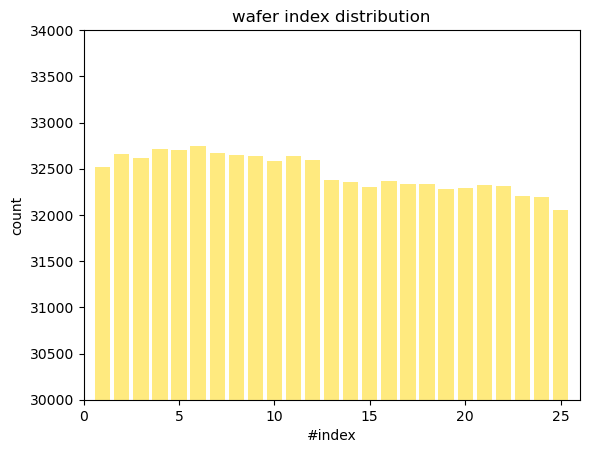

In [75]:
unique_index = np.unique(df.waferIndex, return_counts=True)
plt.bar(unique_index[0], unique_index[1], color='gold', align='center', alpha=0.5)
plt.title('wafer index distribution')
plt.xlabel('#index')
plt.ylabel('count')
plt.xlim(0, 26)
plt.ylim(30000, 34000)
plt.show()

In [76]:
def find_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return (dim0, dim1)

df['waferMapDim'] = df.waferMap.apply(find_dim)
df.sample(5)

waferMap  dieSize   lotName  \
746636  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2,...    518.0  lot44909   
175339  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   2393.0  lot11213   
101467  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1507.0   lot7006   
745191  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 2,...    518.0  lot44852   
206626  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   4169.0  lot13139   

        waferIndex trianTestLabel failureType waferMapDim  
746636        22.0             []          []    (27, 25)  
175339         7.0             []          []    (52, 59)  
101467         3.0             []          []    (44, 44)  
745191         2.0   [[Training]]    [[none]]    (27, 25)  
206626         4.0             []          []    (84, 63)

In [77]:
max(df['waferMapDim']), min(df['waferMapDim'])

((300, 202), (6, 21))

In [78]:
unique_waferDim = np.unique(df['waferMapDim'])
unique_waferDim.shape

(632,)

In [79]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel

mapping_type={
    'Center':0,
    'Donut':1,
    'Edge-Loc':2,
    'Edge-Ring':3,
    'Loc':4,
    'Random':5,
    'Scratch':6,
    'Near-full':7,
    'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [80]:
df_label = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_label = df_label.reset_index()
df_pattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_pattern = df_pattern.reset_index()
df_none = df[(df['failureNum']==8)]

df_label.shape[0], df_pattern.shape[0], df_none.shape[0]

(172950, 25519, 147431)

In [81]:
tol_wafers = df.shape[0]
tol_wafers

811457

/var/folders/z_/xvvp4h796z9ggg4w6w81n__m0000gq/T/ipykernel_17054/1186344278.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels2)


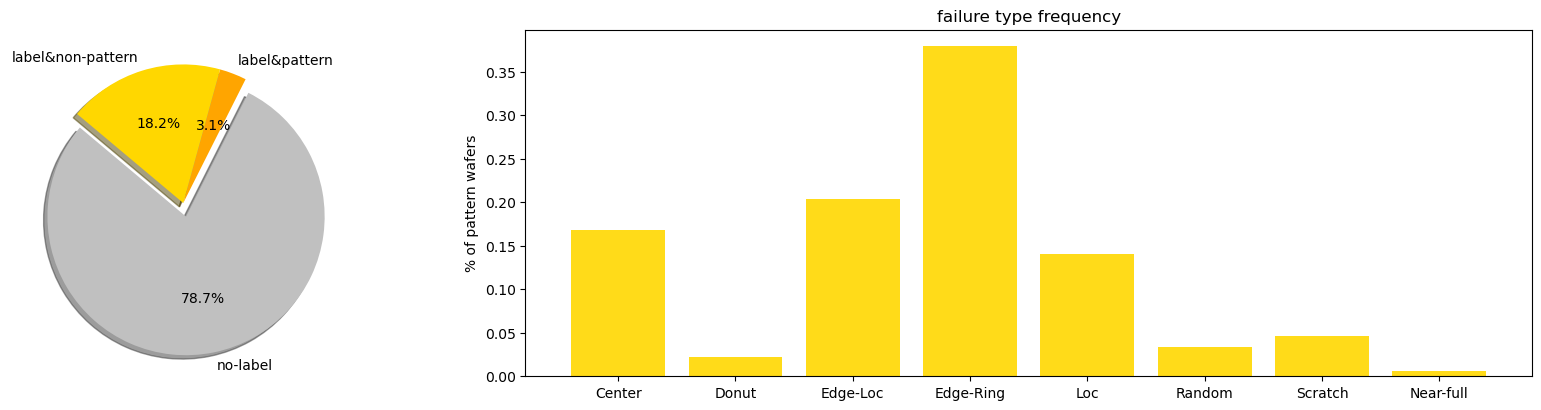

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_label.shape[0], df_pattern.shape[0], df_none.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_pattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_pattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()


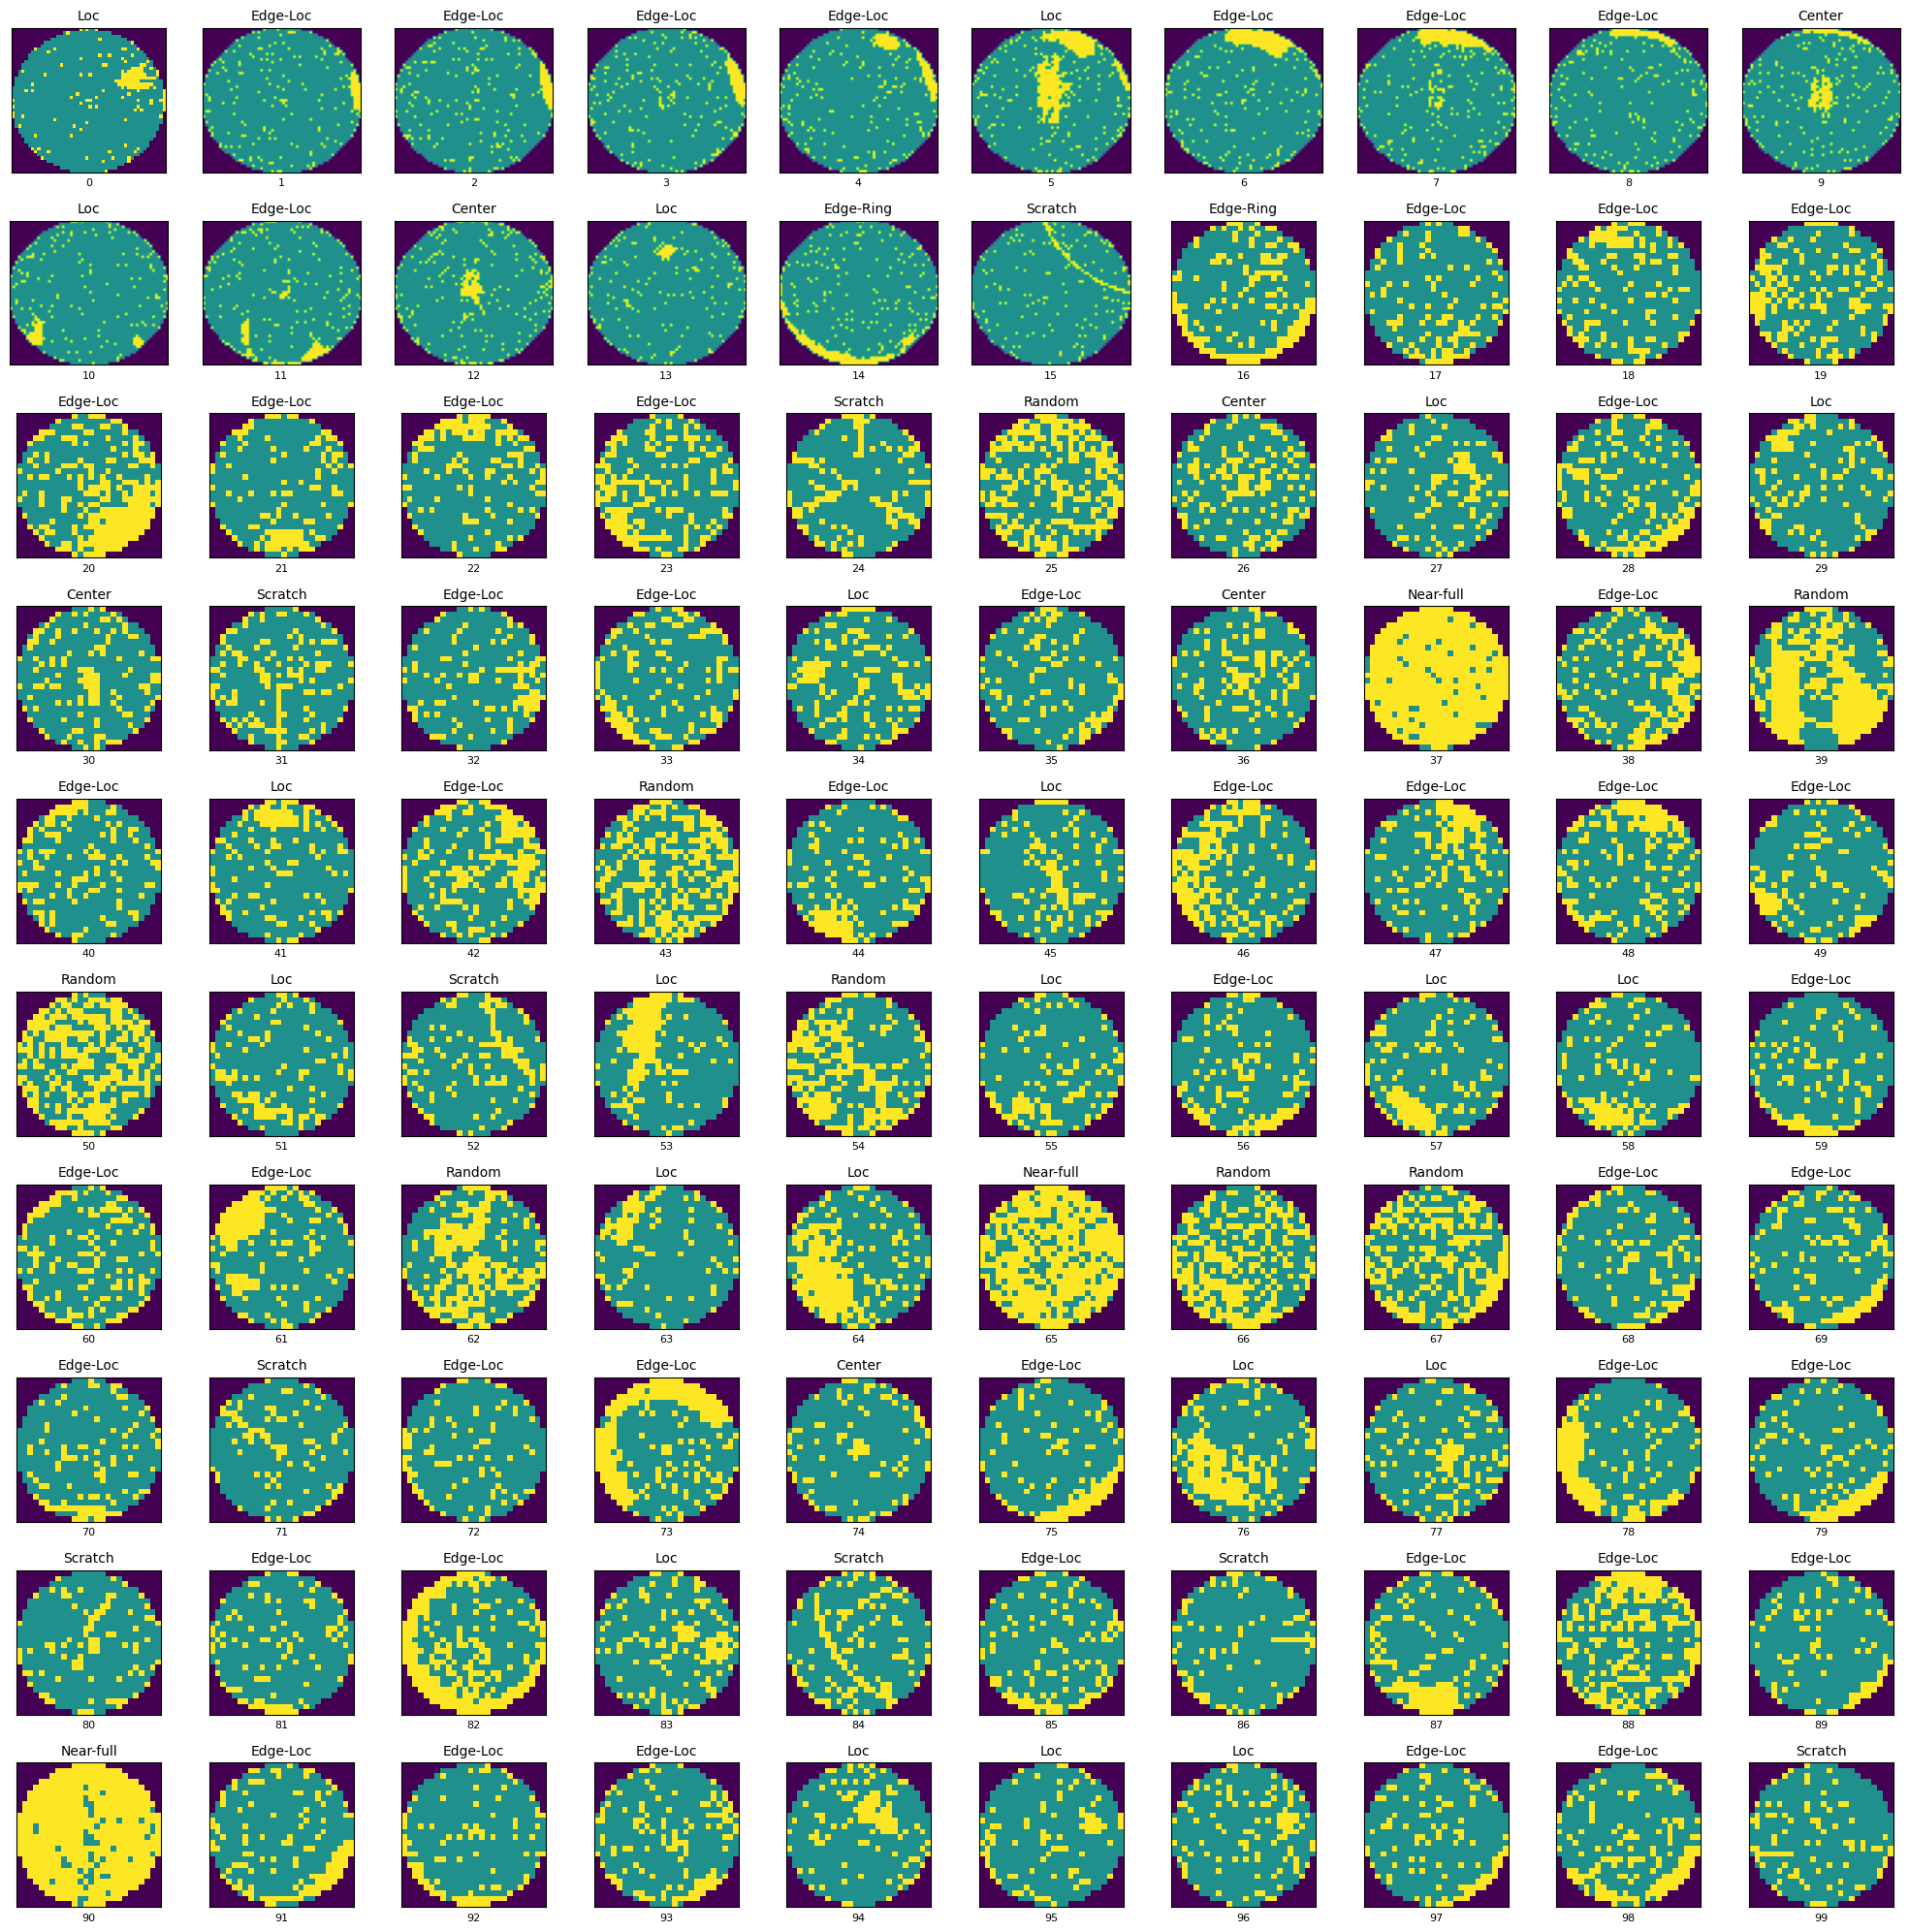

In [83]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_pattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_pattern.failureType[i][0][0], fontsize=10)
    ax[i].set_xlabel(df_pattern.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

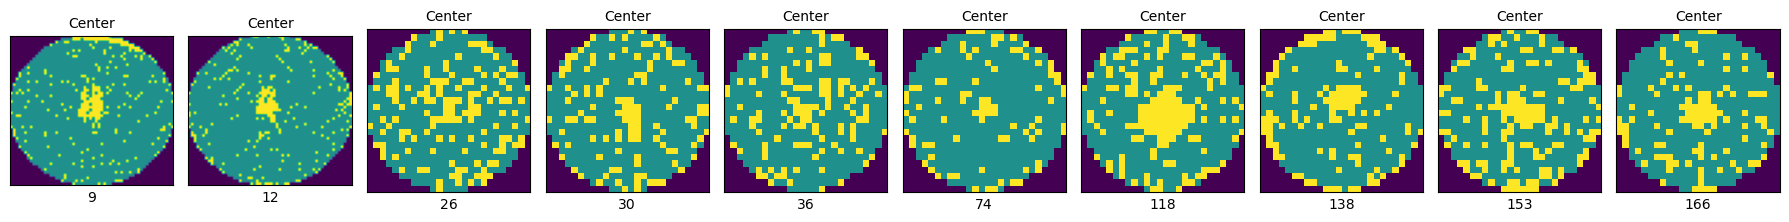

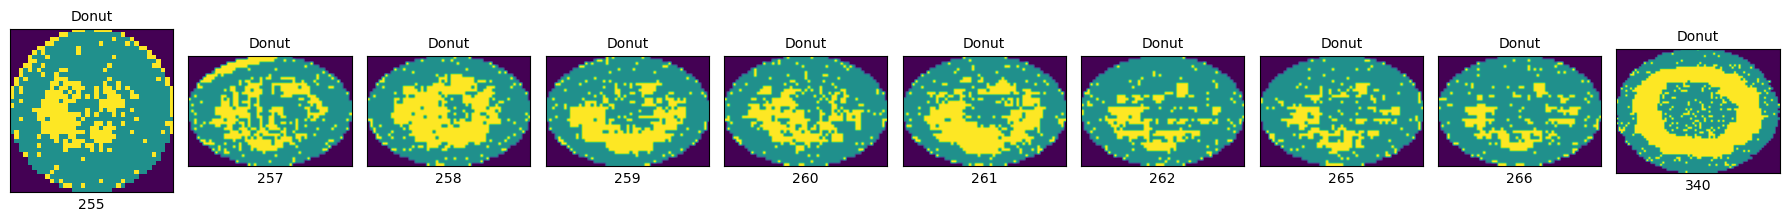

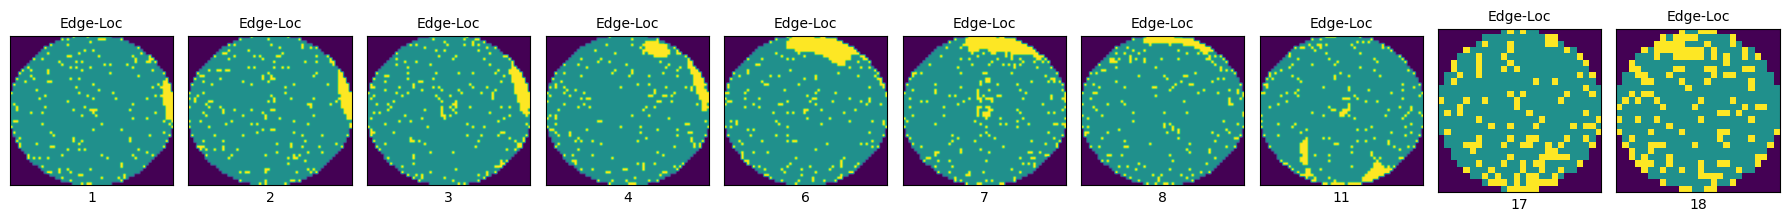

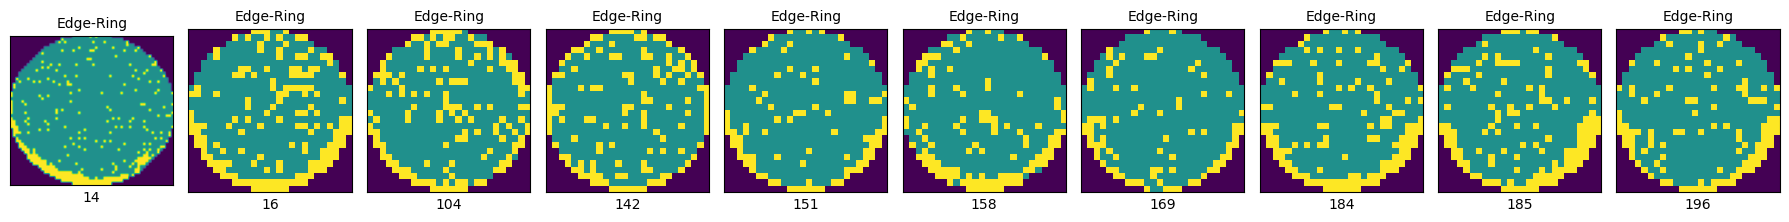

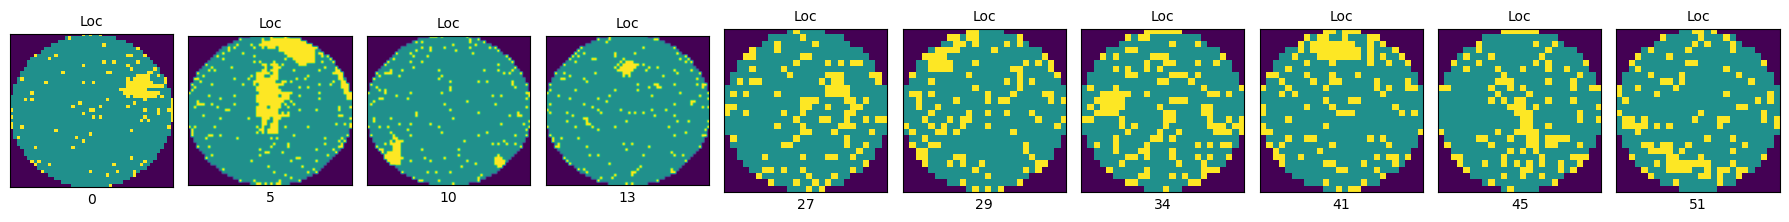

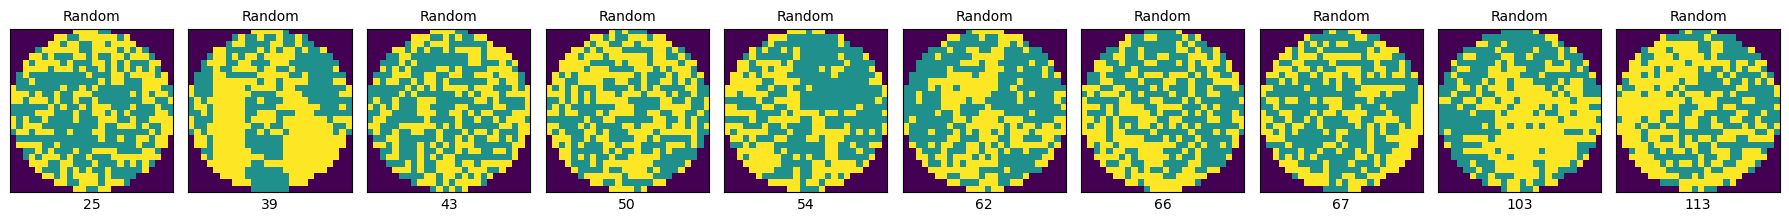

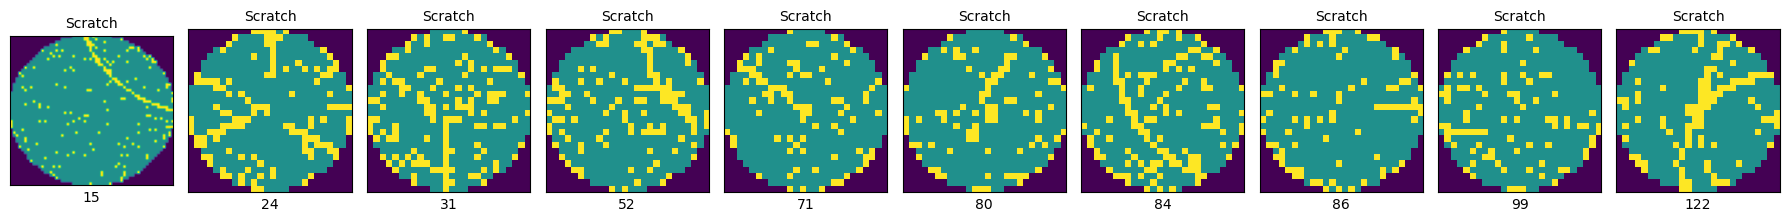

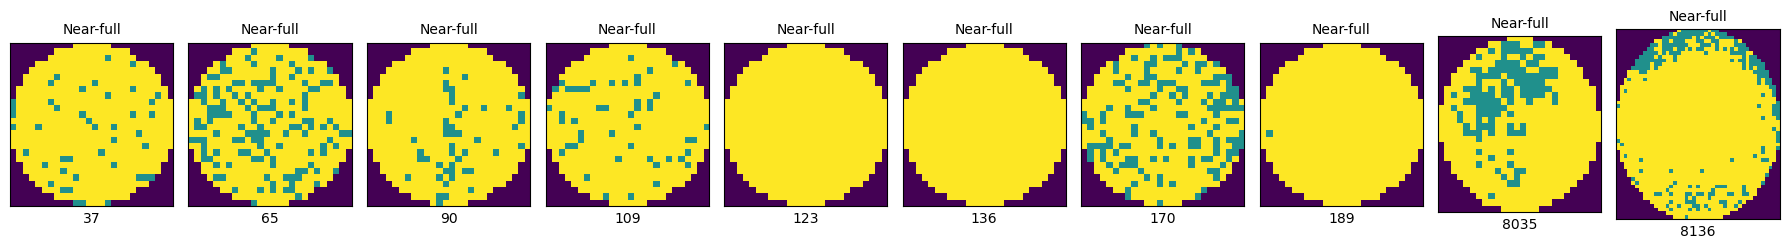

In [84]:
x = [0,1,2,3,4,5,6,7]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_pattern.waferMap[df_pattern.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_pattern.failureType[img.index[i]][0][0], fontsize=10)
            ax[i].set_xlabel(df_pattern.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

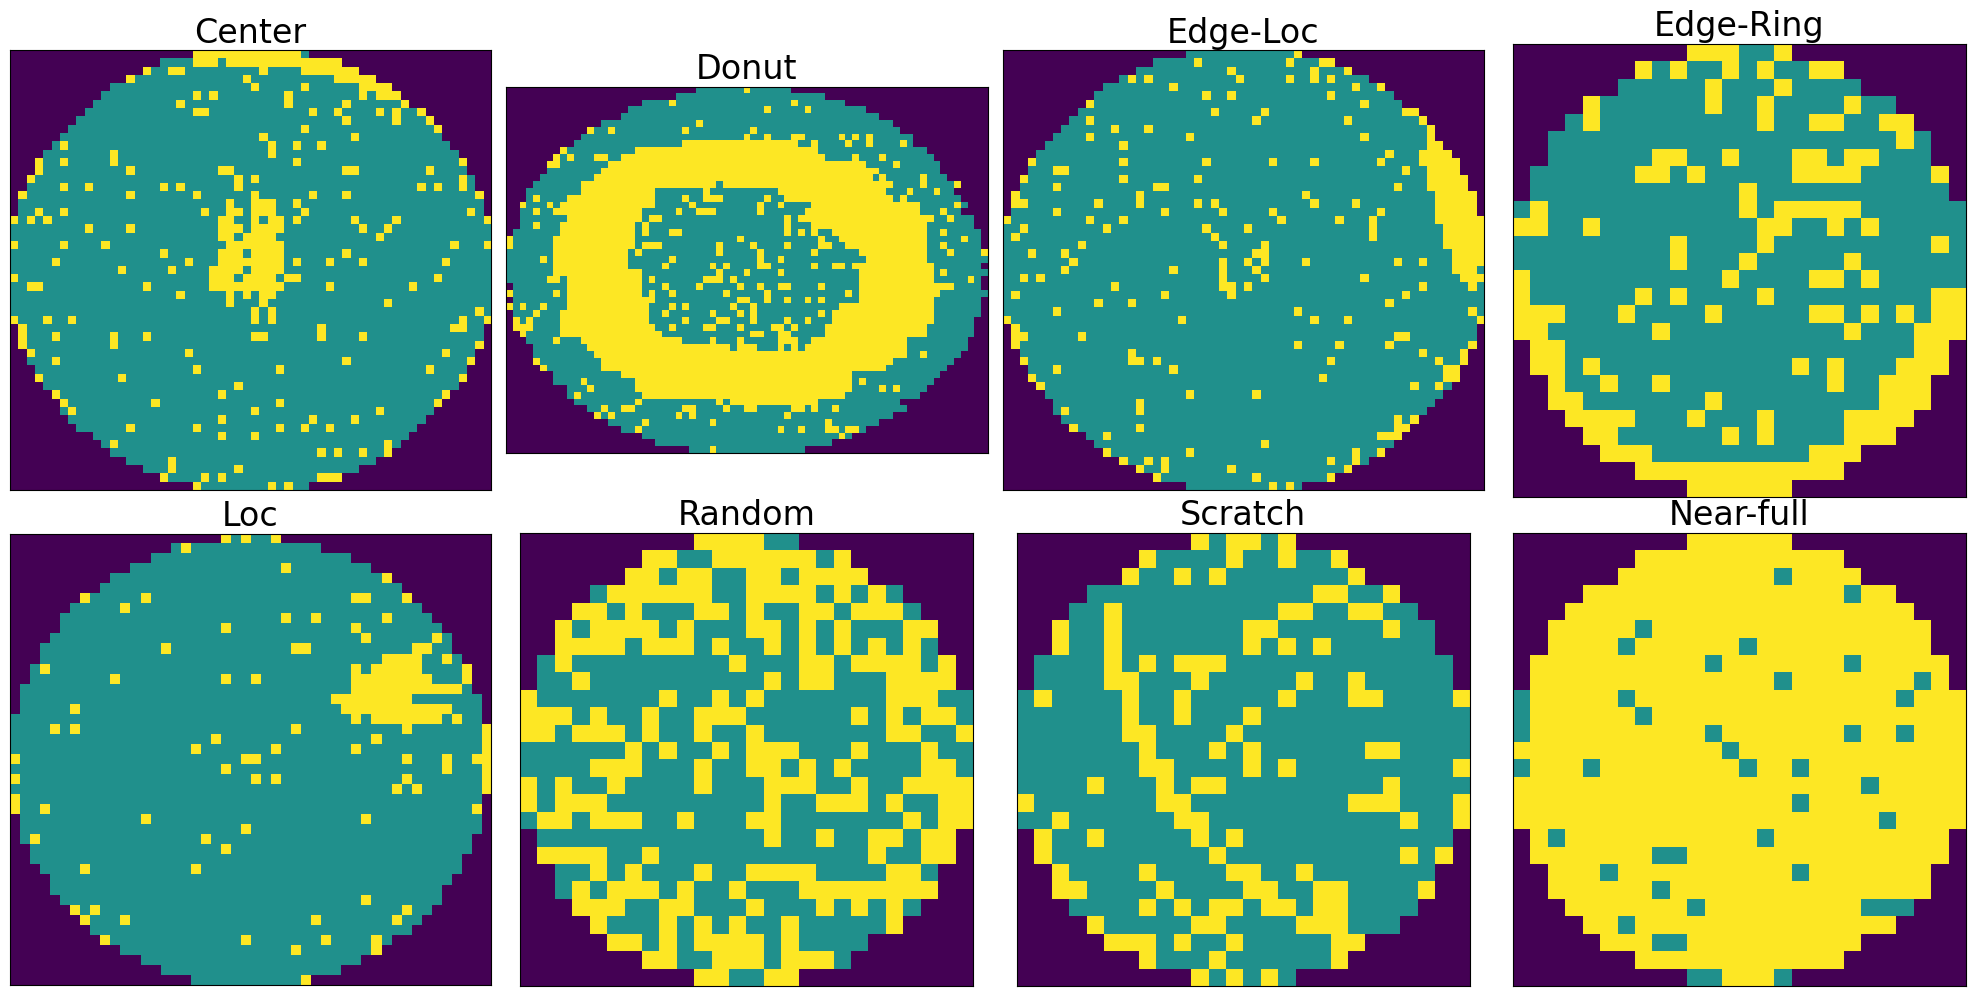

In [85]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

#ind_def = {'Center': 9, 'Donut': 340, 'Edge-Loc': 3, 'Edge-Ring': 16, 'Loc': 0, 'Random': 25,  'Scratch': 84, 'Near-full': 37}
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_pattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_pattern.failureType[x[i]][0][0],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [86]:
del df
del df_pattern
del df_none

In [87]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPool2D
from tensorflow.keras.layers import Flatten, Softmax, SpatialDropout2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [88]:
model = Sequential([
    # Input
    Input(shape=(224, 224, 3)),
    
    # block 1
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # block 2
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # block 3
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),

    # block 4
    Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    
    # block 5
    SpatialDropout2D(rate=0.2),
    MaxPool2D(pool_size=(2,2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dense(9, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 222, 222, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 111, 111, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 111, 111, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 111, 111, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 55, 55, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 55, 55, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 55, 55, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 55, 55, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 27, 27, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 27, 27, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 27, 27, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 27, 27, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 13, 13, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 13, 13, 128)    │             

 Total params: 2,536,985 (9.68 MB)

 Trainable params: 2,536,025 (9.67 MB)

 Non-trainable params: 960 (3.75 KB)

In [89]:
import cv2

def reshape_images(images, height, width):
    reshaped_images = np.zeros((len(images), height, width, 3))
    for n in range(len(images)):
        for h in range(height):
            for w in range(width):
                reshaped_images[n, h, w, images[n][h][w]] = 1
    return reshaped_images

def augment_images(images, number=None):
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
            rotate=(-180, 180),
            shear=(-8, 8)
        ),
    ], random_order=True)
    
    images_input = np.random.choice(images, number) if number else images
    images_expanded = []
    for image in images_input:
        images_expanded.append(image)
    images_expanded = np.array(images_expanded)
    images_augmented = seq(images=images_expanded)
    return images_augmented

In [90]:
import gc
gc.collect()

59184

In [91]:
class_num = 9
dsize = (224, 224)
count_per_class_test = 20
count_per_class = 80

x_test, y_test = [], []
for failureNum in range(class_num):
    extracted = df_label[df_label['failureNum'] == failureNum].sample(count_per_class_test, replace=True).waferMap
    resized = extracted.apply(lambda x:cv2.resize(x, dsize=dsize, interpolation=cv2.INTER_AREA))
    del extracted
    augmented = np.array(augment_images(resized))
    reshaped = reshape_images(augmented, dsize[1], dsize[0])
    del augmented

    labels = np.zeros((count_per_class_test, class_num))
    for i in range(count_per_class_test):
        labels[i][failureNum] = 1
        
    x_test.extend(reshaped)
    y_test.extend(labels)
x_test = np.array(x_test)
y_test = np.array(y_test)

histories = []
for j in range(100):
    x_train, y_train = [], []
    for failureNum in range(class_num):
        extracted = df_label[df_label['failureNum'] == failureNum].sample(count_per_class, replace=True).waferMap
        resized = extracted.apply(lambda x:cv2.resize(x, dsize=dsize, interpolation=cv2.INTER_AREA))
        del extracted
        augmented = np.array(augment_images(resized))
        reshaped = reshape_images(augmented, dsize[1], dsize[0])
        del augmented

        labels = np.zeros((count_per_class, class_num))
        for i in range(count_per_class):
            labels[i][failureNum] = 1

        x_train.extend(reshaped)
        y_train.extend(labels)
#     x_train, x_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.3)
    
    history = model.fit(np.array(x_train), np.array(y_train), validation_data=(x_test, y_test), epochs=20, batch_size=100)
    histories.append(history)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 961ms/step - accuracy: 0.2116 - loss: 8.4141 - val_accuracy: 0.1111 - val_loss: 22.0917
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 783ms/step - accuracy: 0.4081 - loss: 2.9030 - val_accuracy: 0.1222 - val_loss: 11.1854
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 786ms/step - accuracy: 0.5867 - loss: 1.2967 - val_accuracy: 0.2000 - val_loss: 7.2902
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 779ms/step - accuracy: 0.6656 - loss: 0.9255 - val_accuracy: 0.2278 - val_loss: 3.2972
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 754ms/step - accuracy: 0.7697 - loss: 0.6447 - val_accuracy: 0.2278 - val_loss: 2.4483
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 772ms/step - accuracy: 0.8034 - loss: 0.5256 - val_accuracy: 0.2278 - val_loss: 2.2748
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 788ms/step - accuracy: 0.8881 - loss: 0.3799 - val_accuracy: 0.2833 - val_loss: 2.0911
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 755ms/step - accuracy: 0.9390 - loss: 0.2413 - val_accuracy: 0.2333 - val_lo

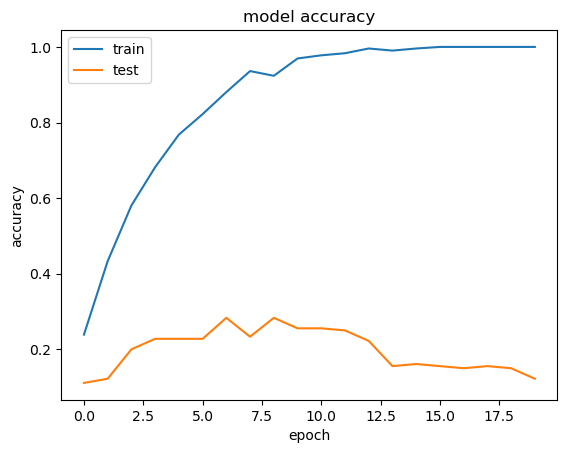

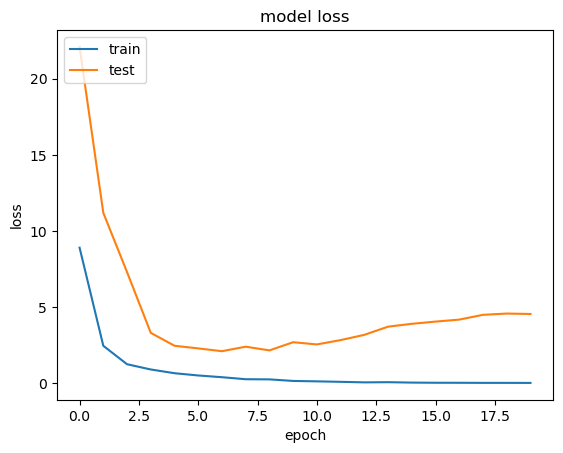

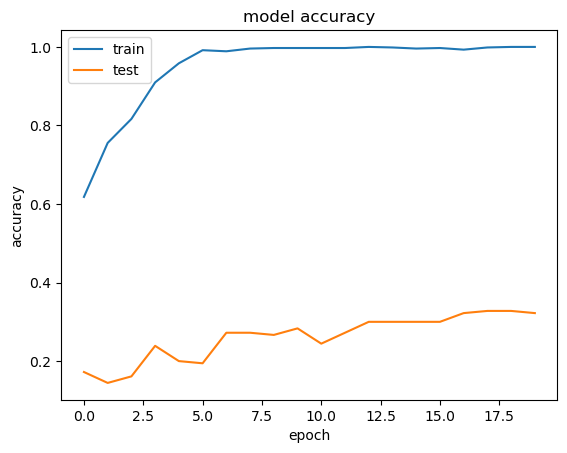

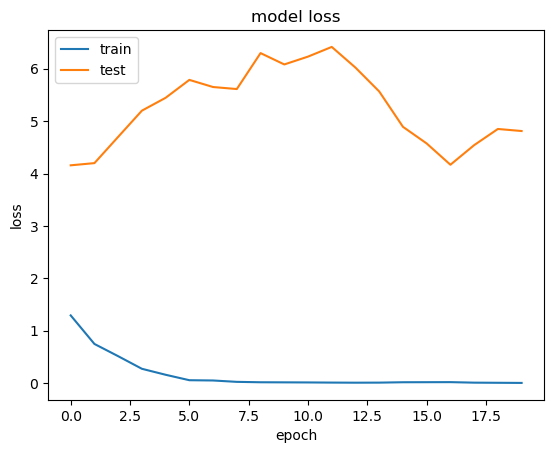

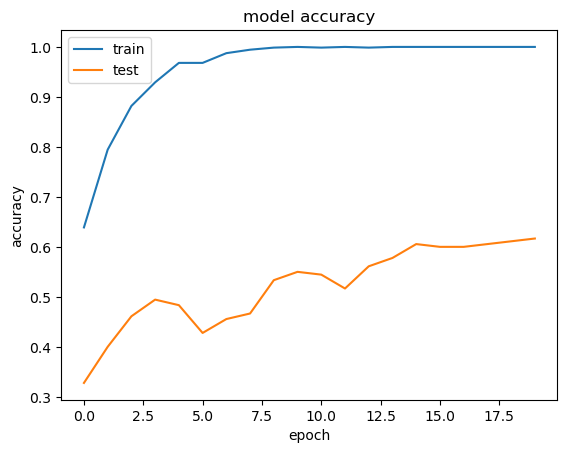

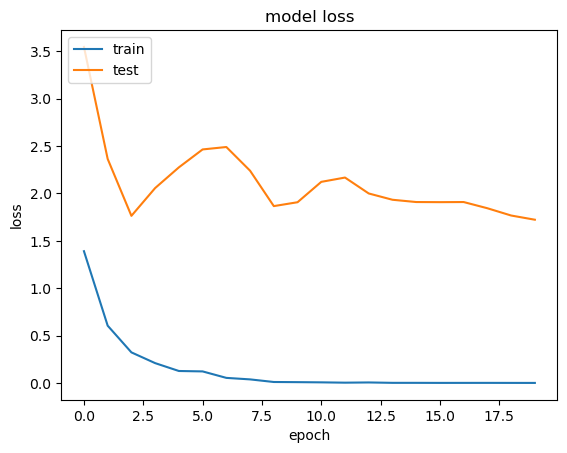

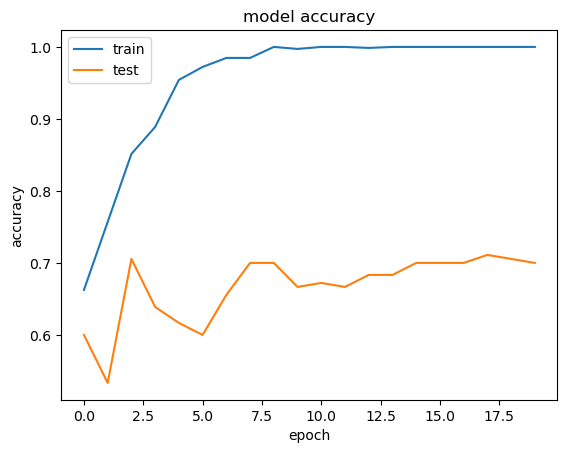

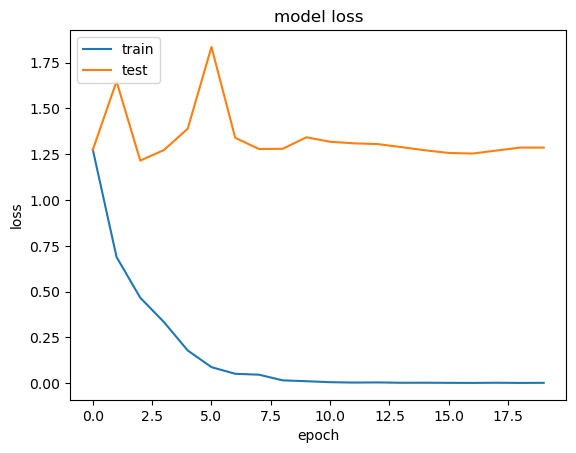

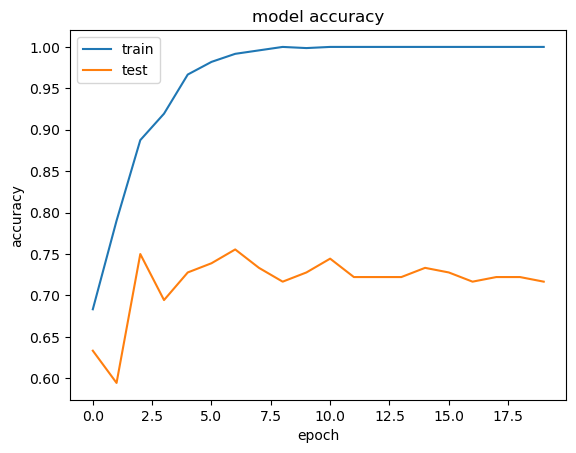

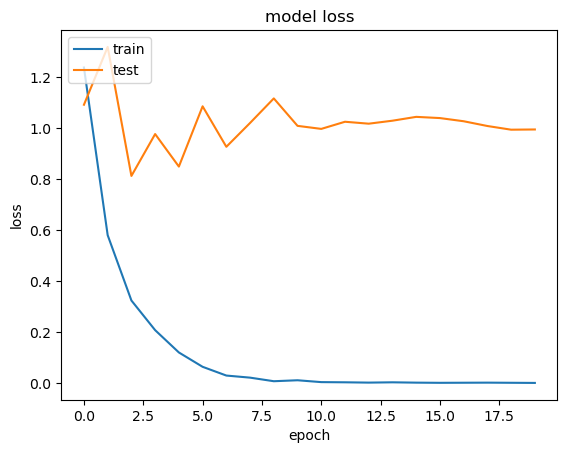

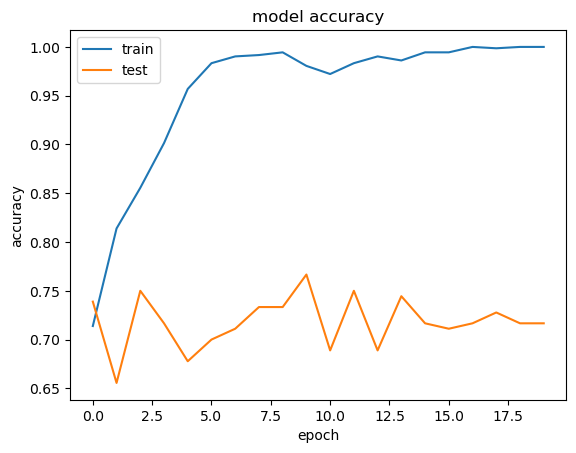

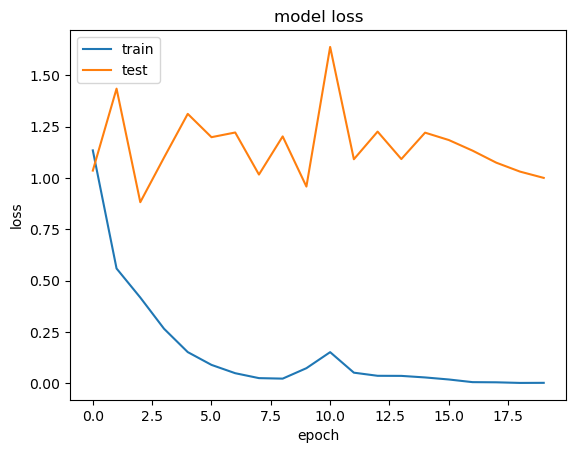

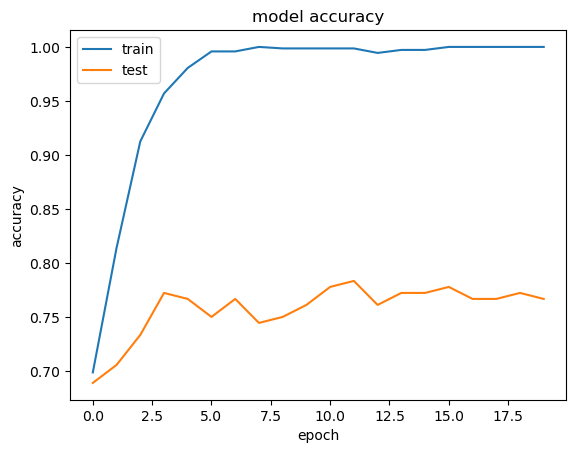

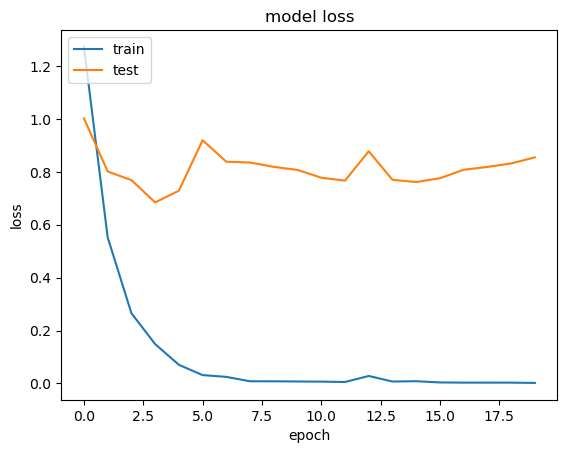

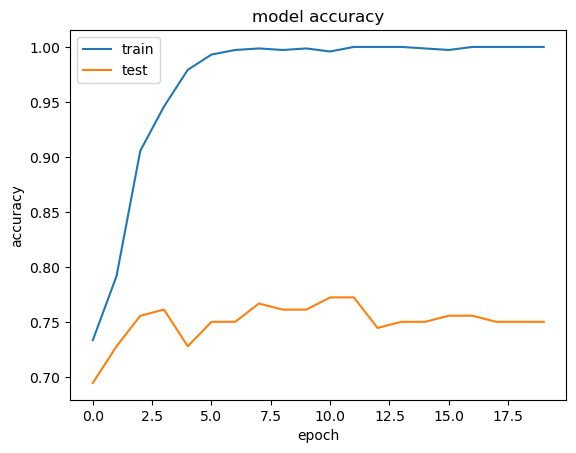

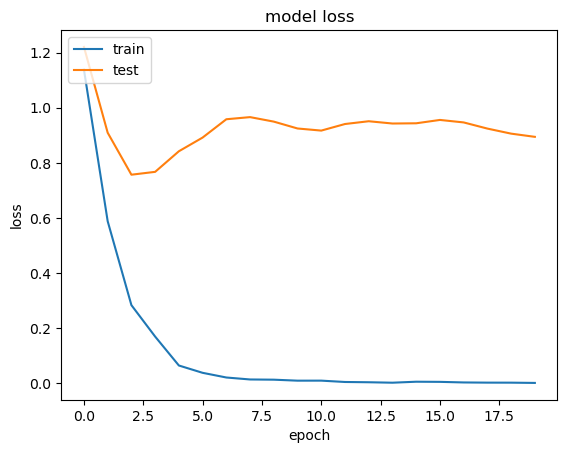

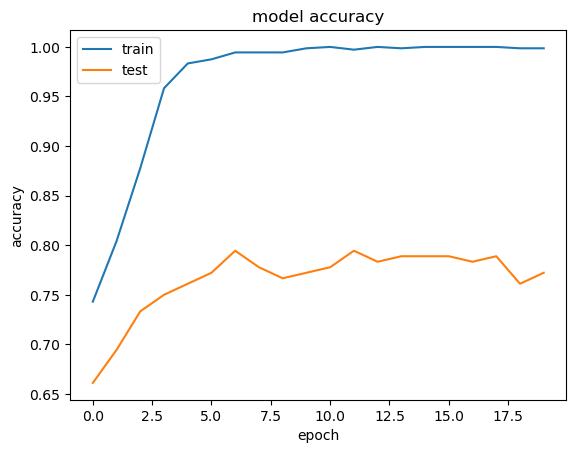

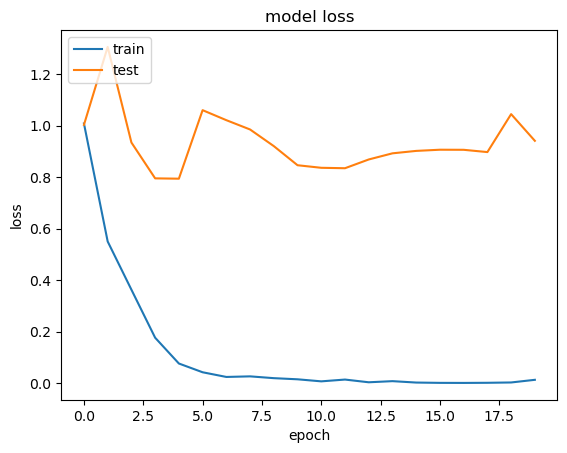

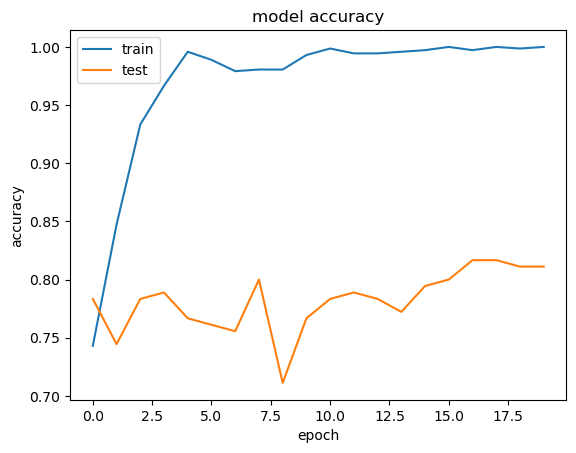

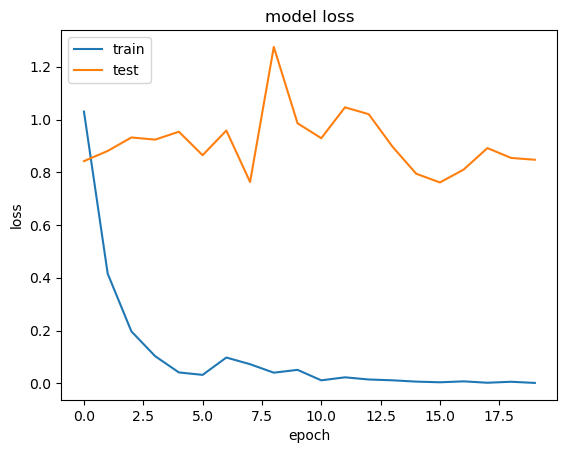

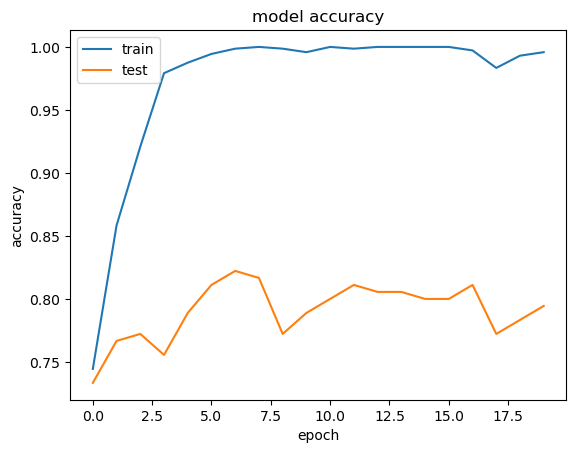

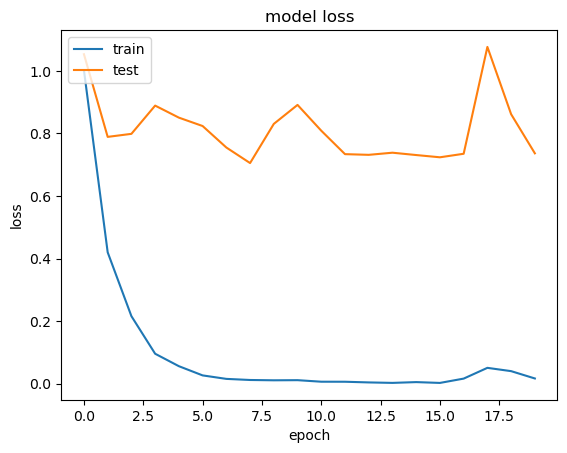

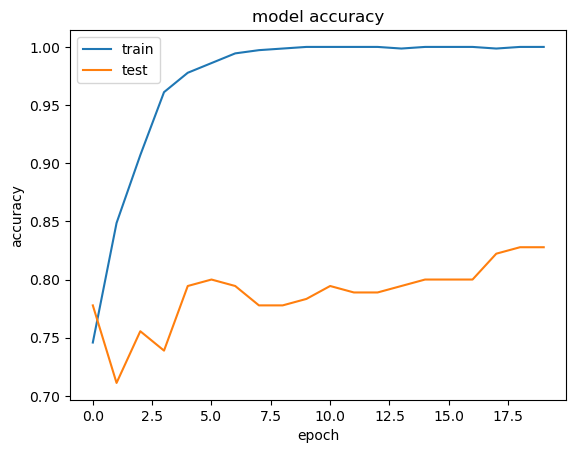

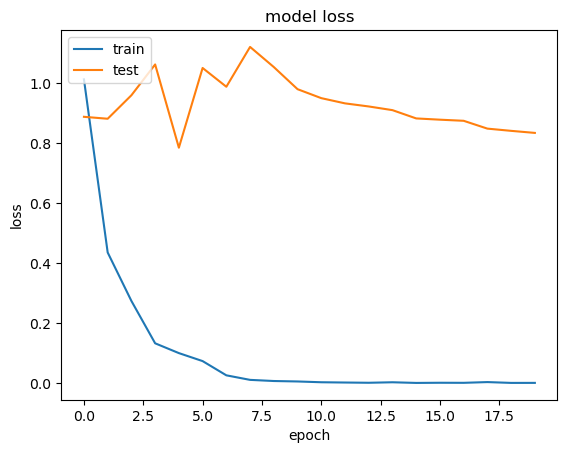

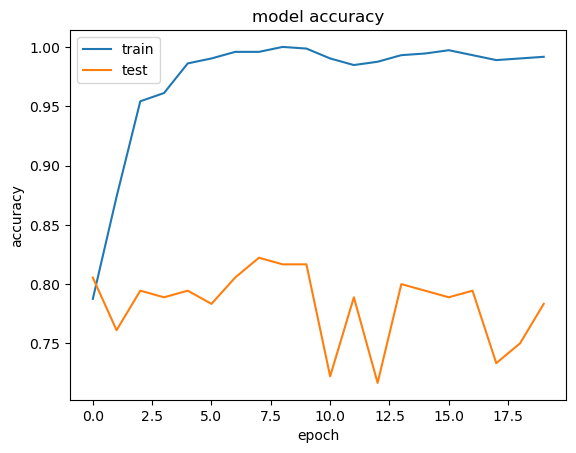

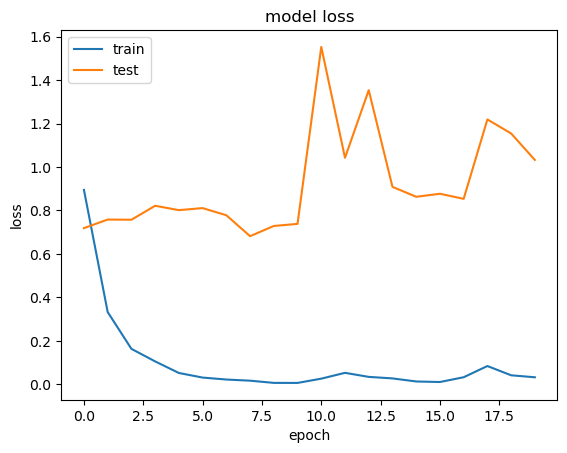

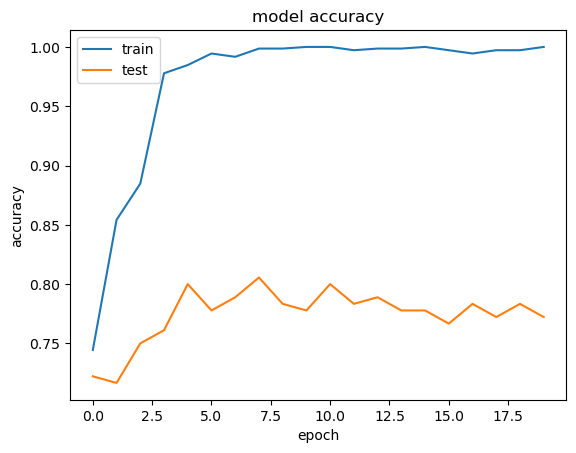

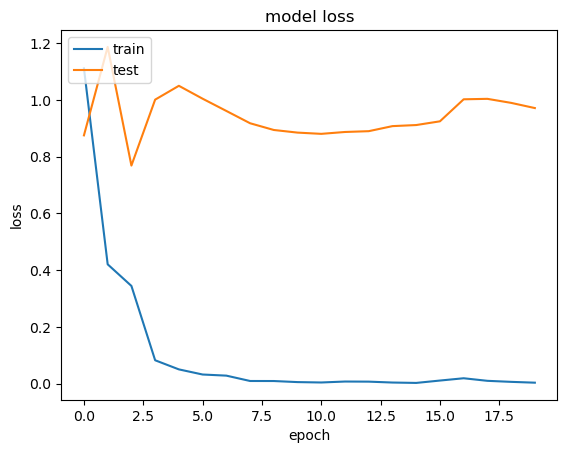

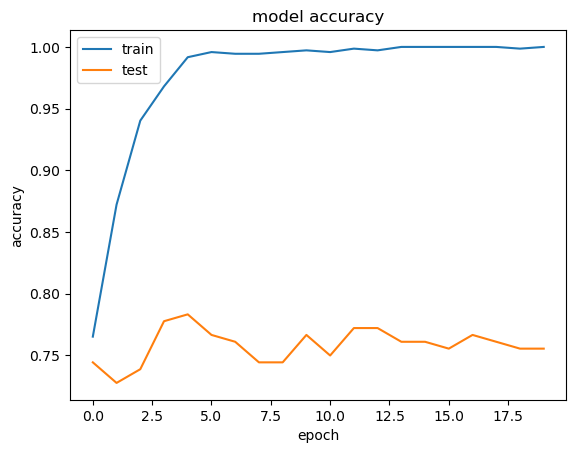

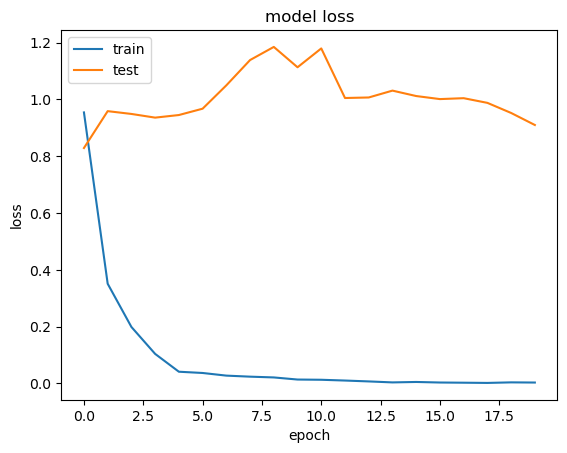

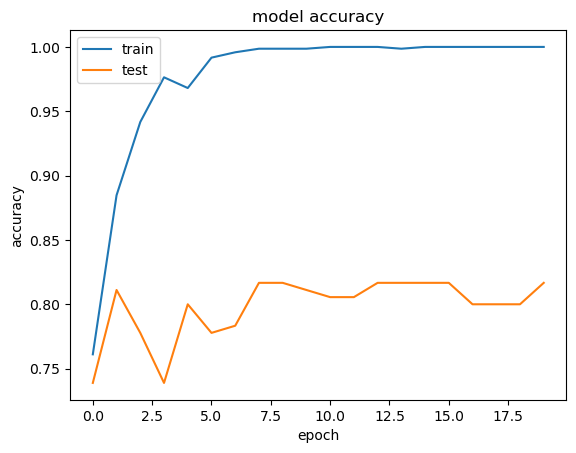

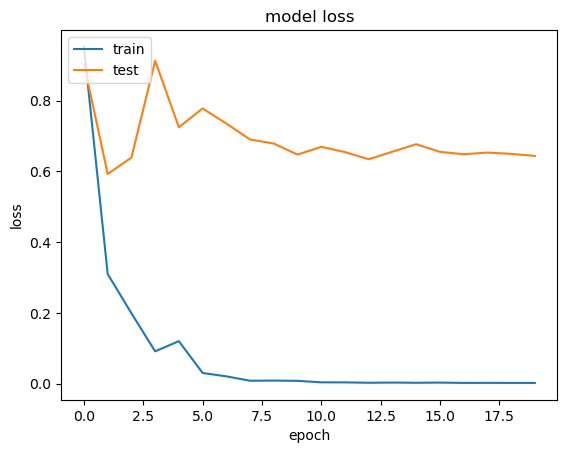

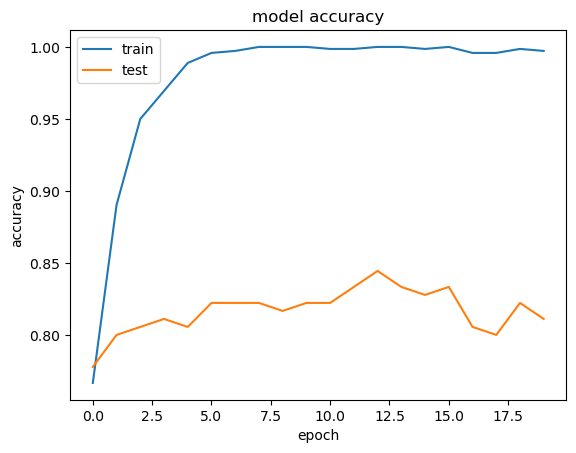

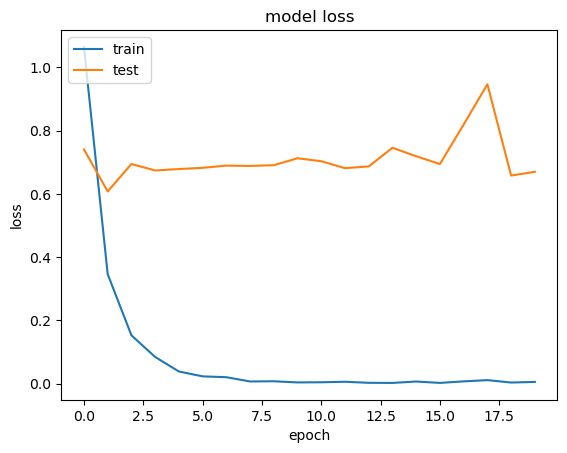

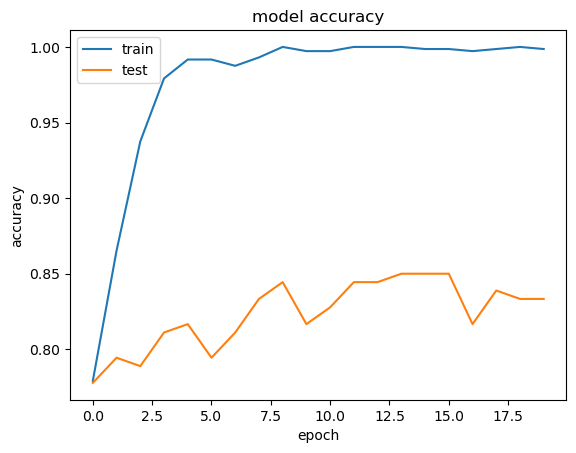

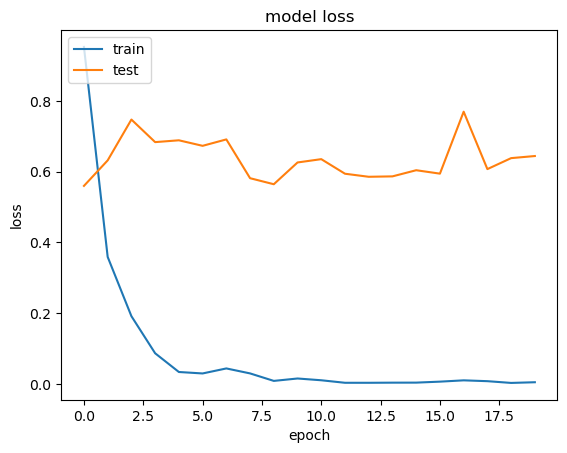

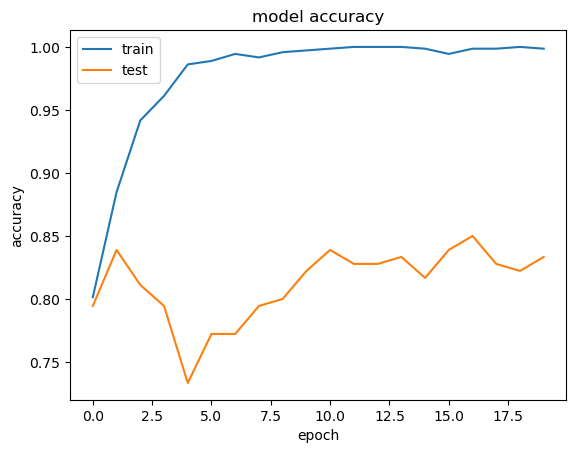

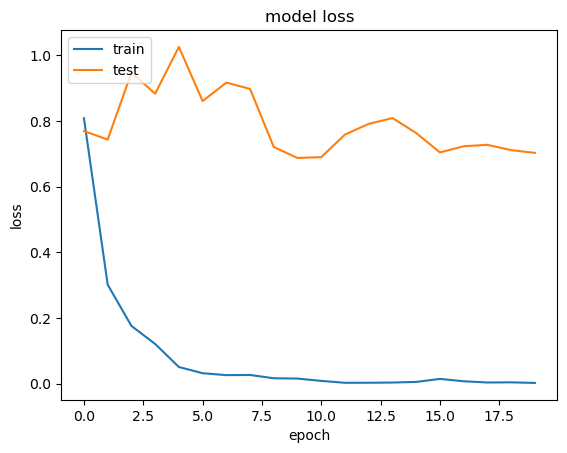

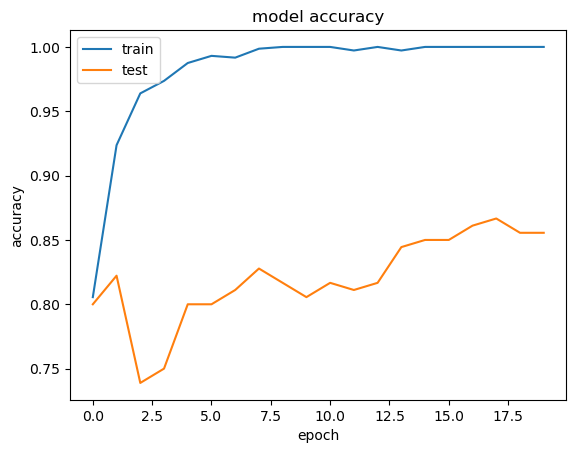

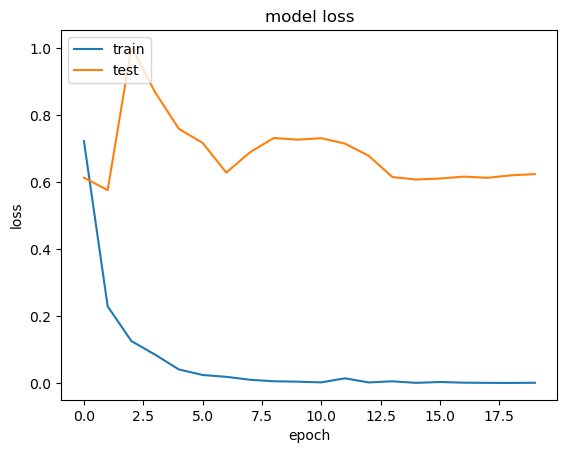

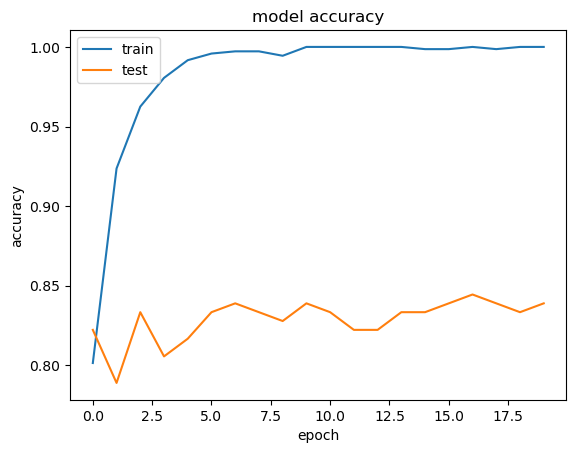

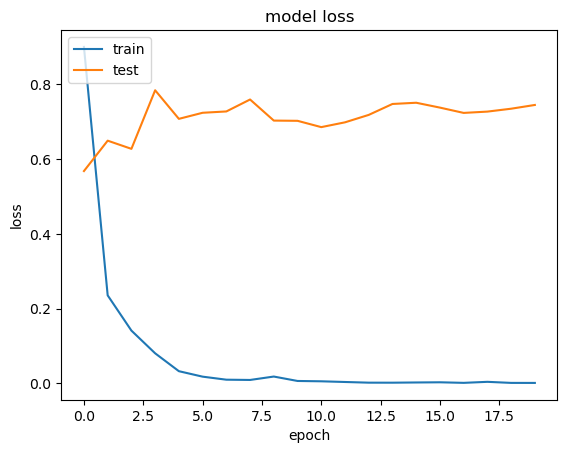

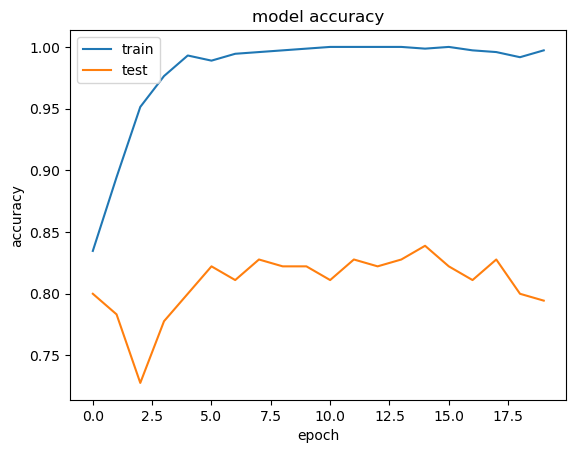

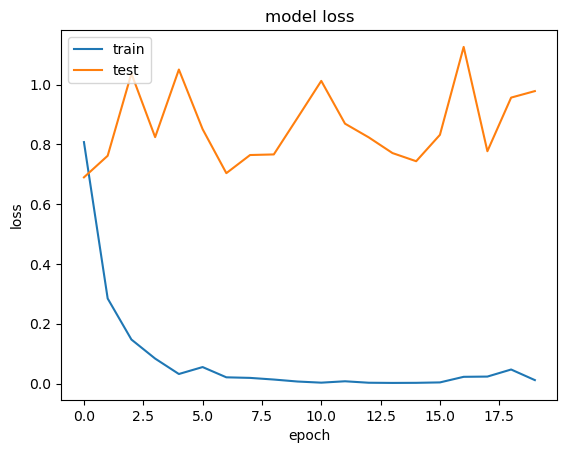

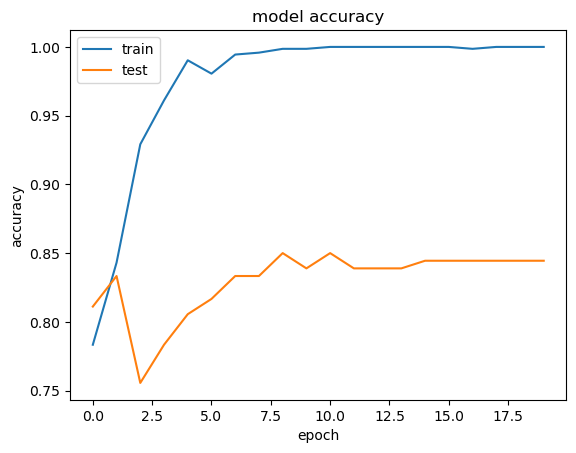

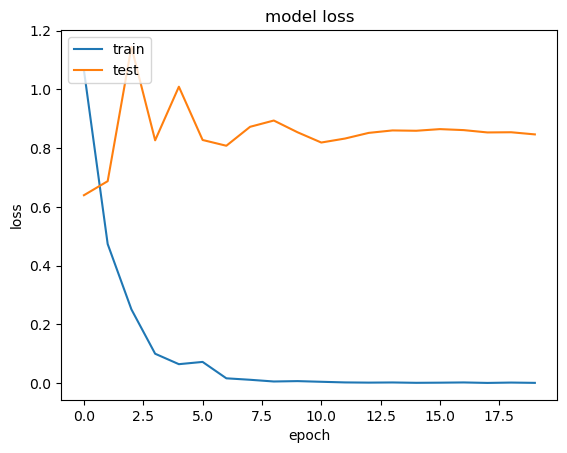

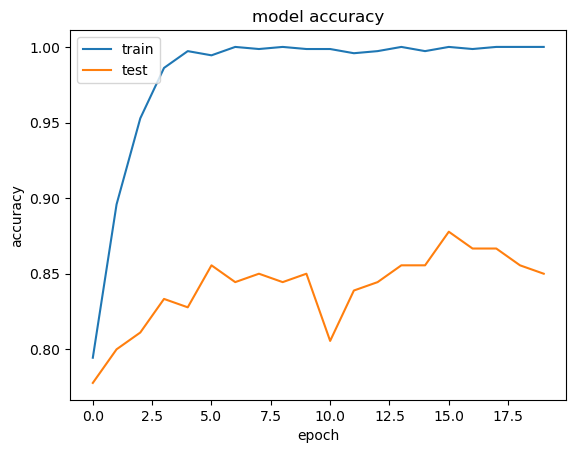

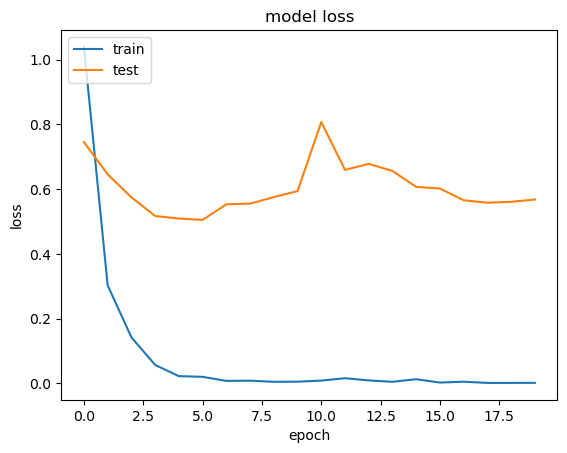

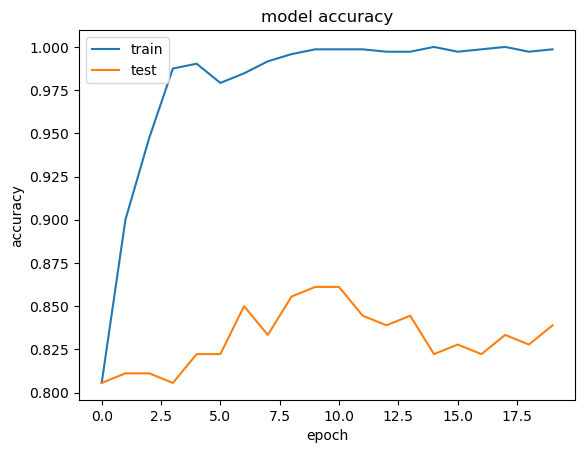

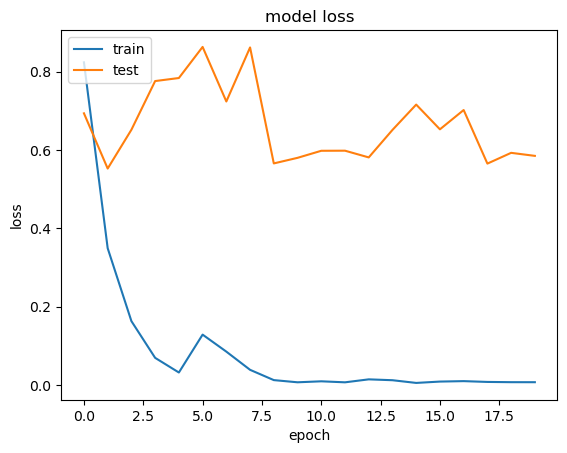

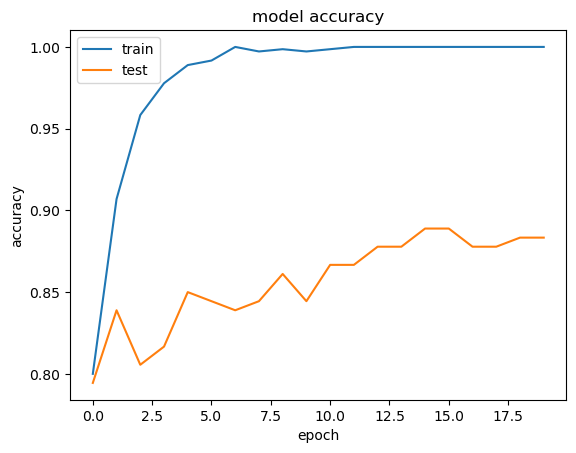

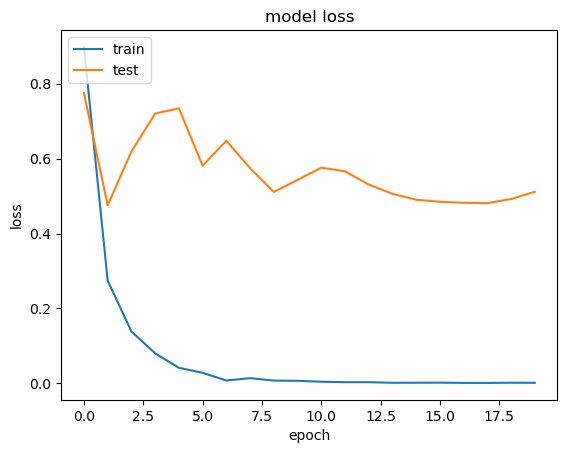

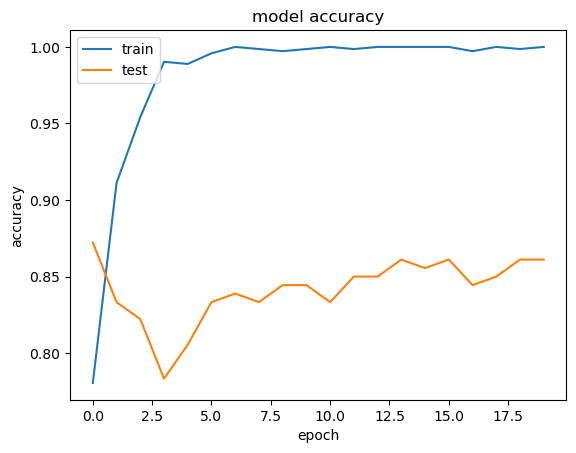

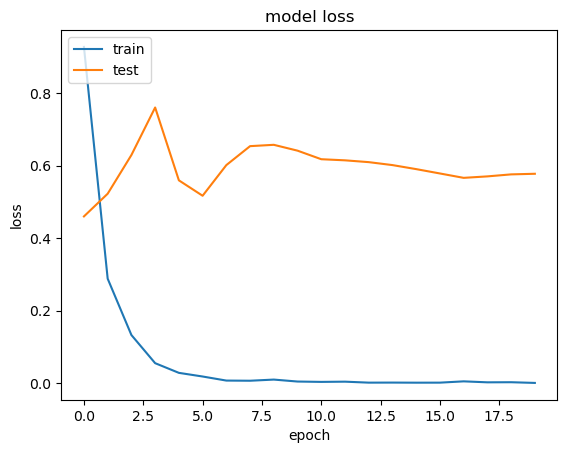

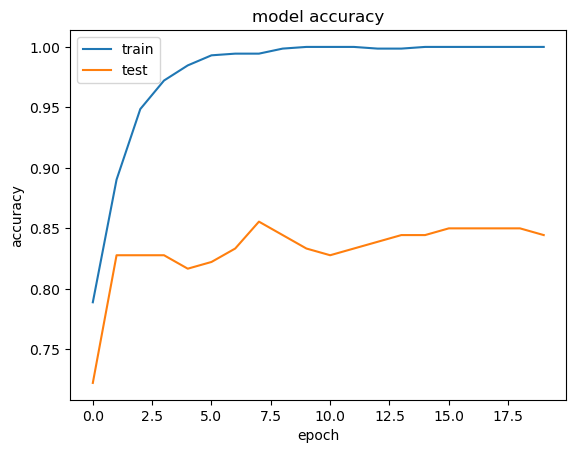

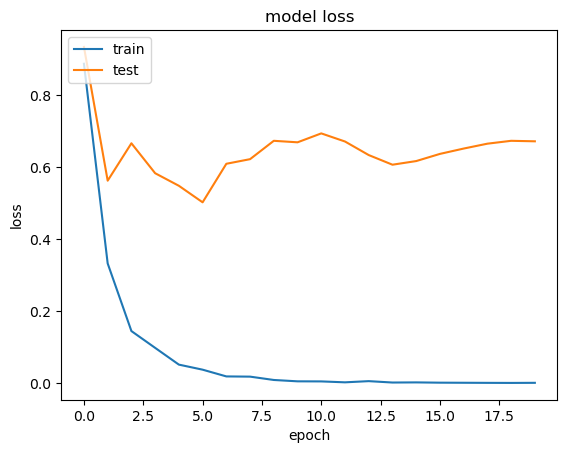

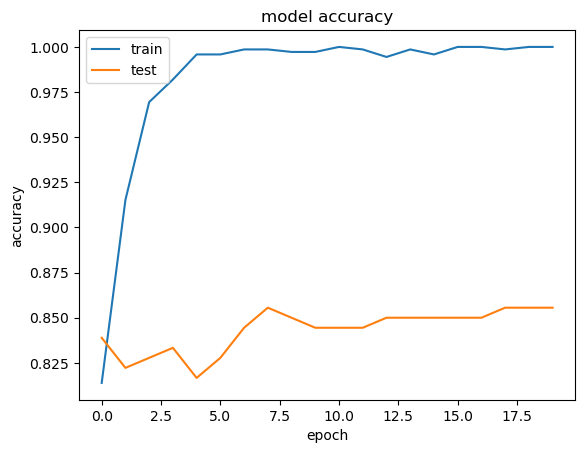

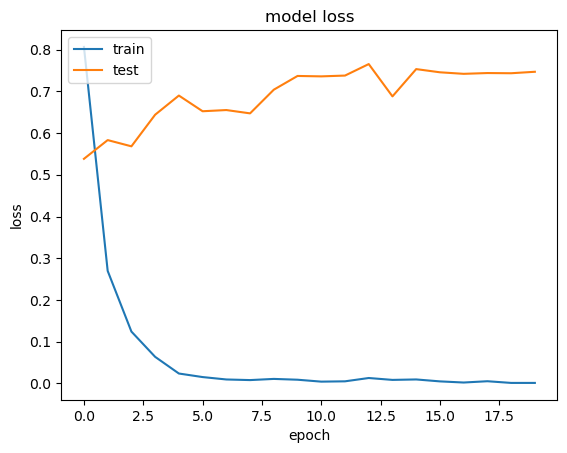

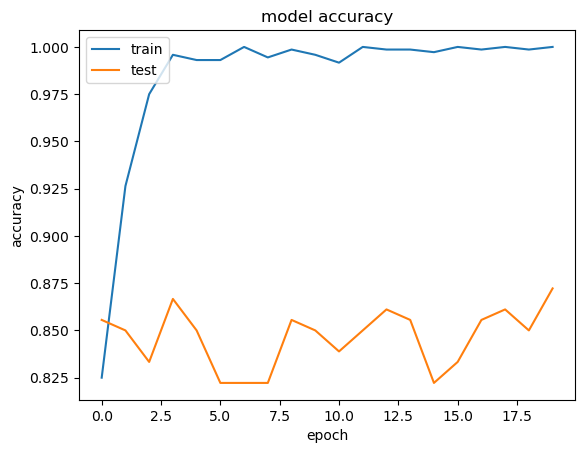

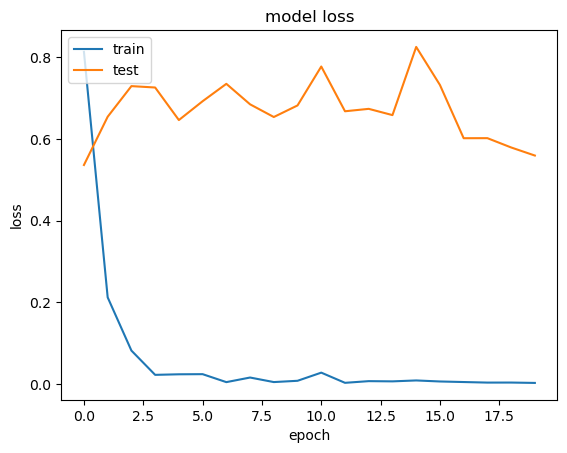

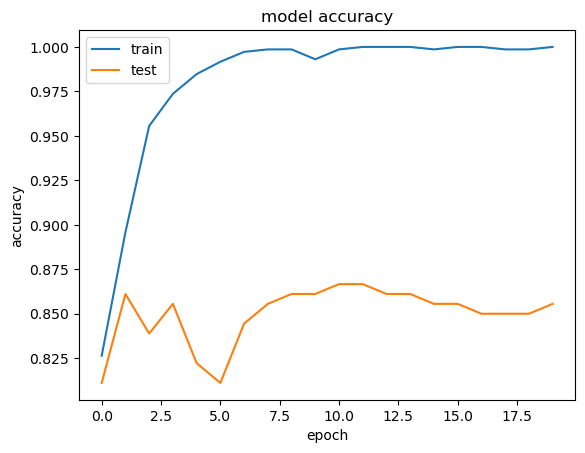

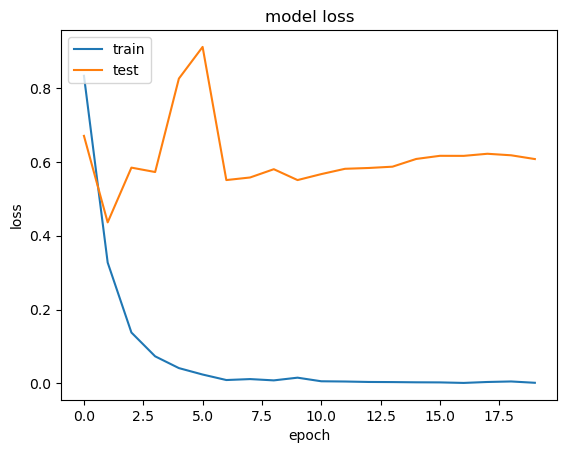

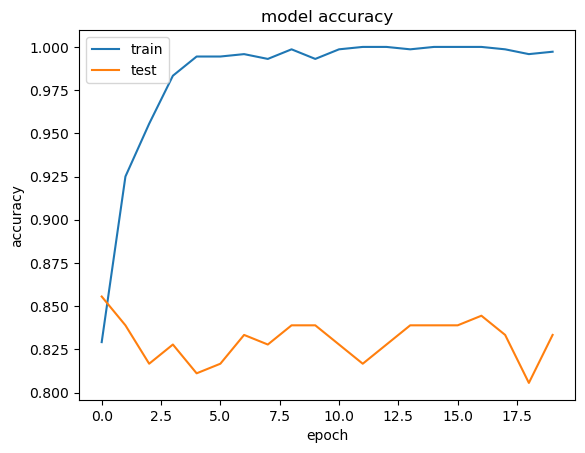

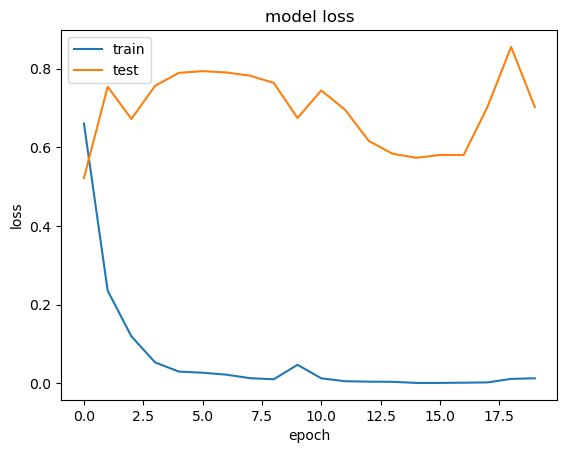

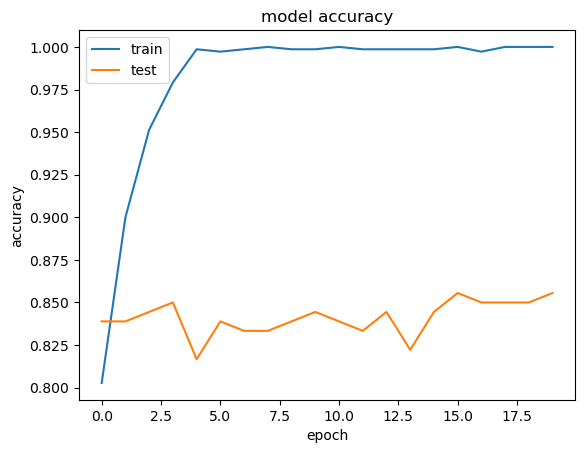

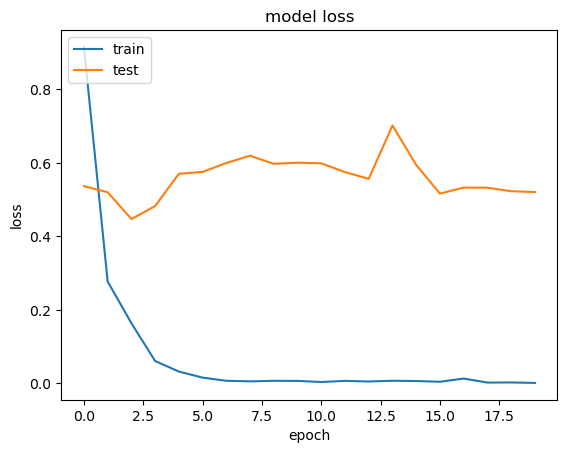

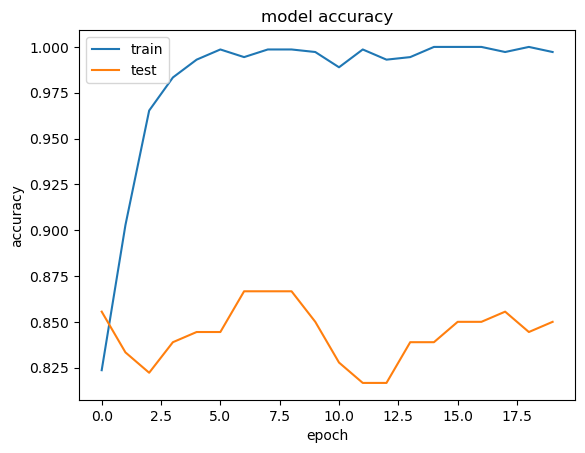

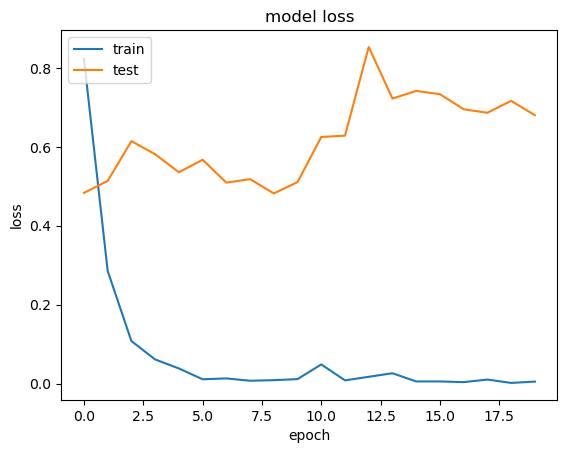

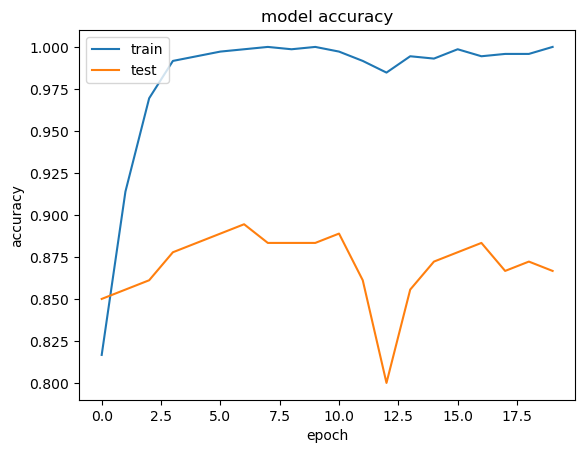

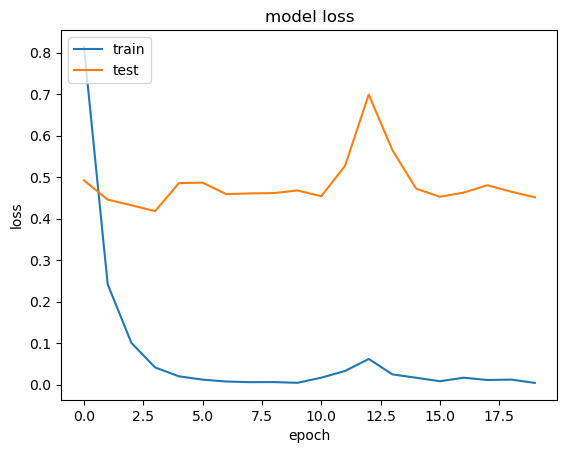

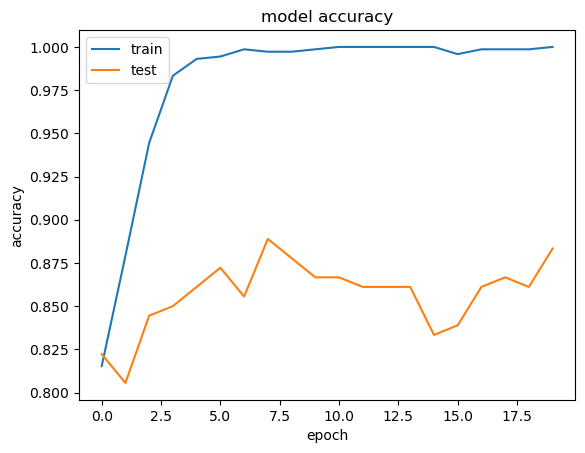

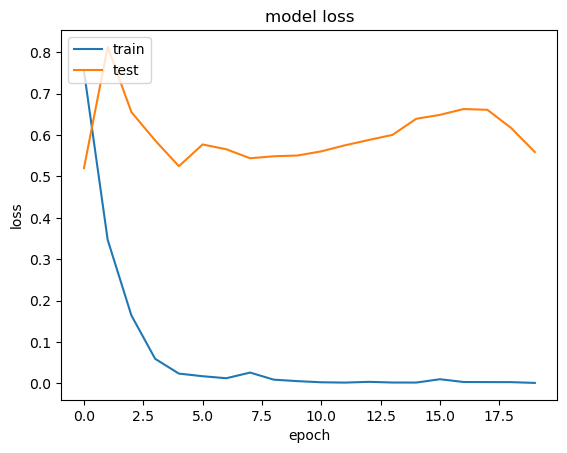

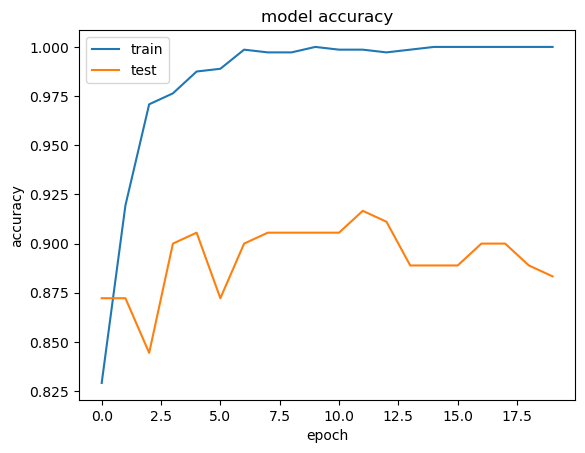

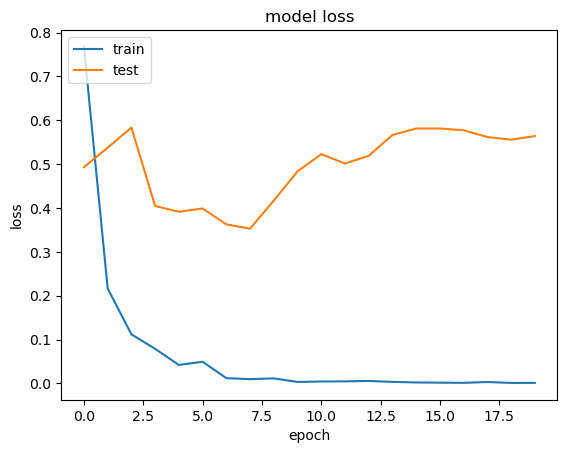

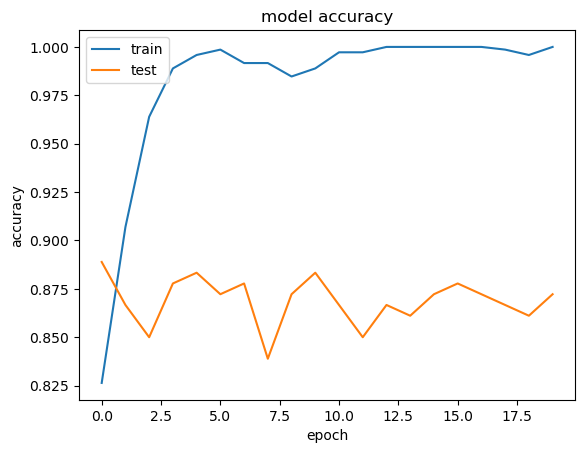

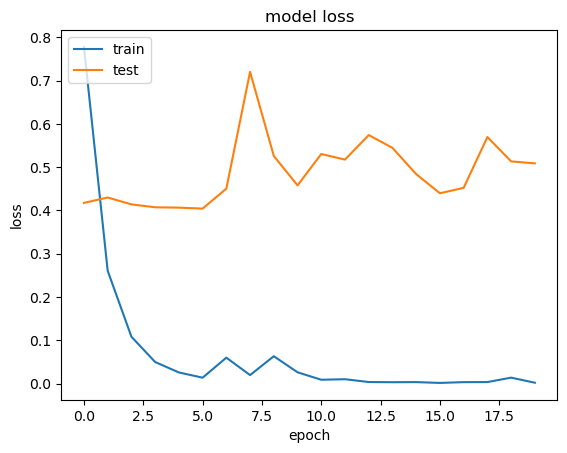

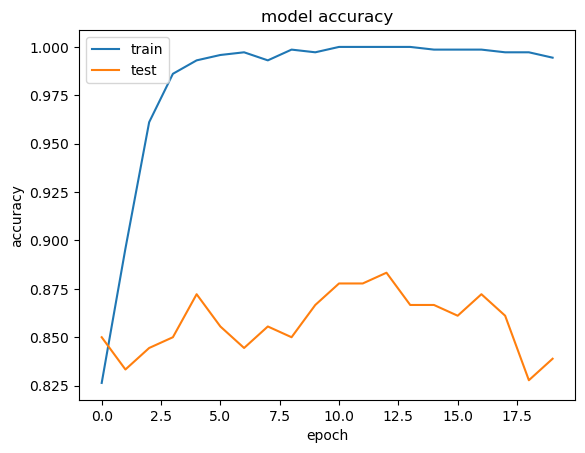

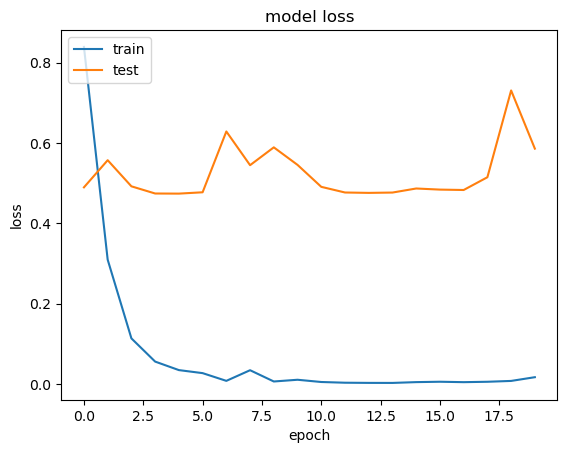

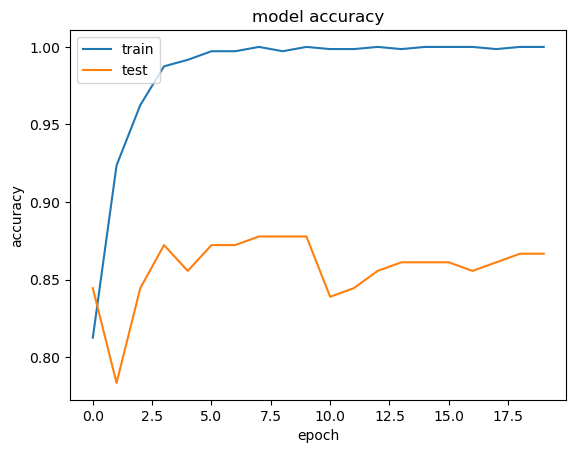

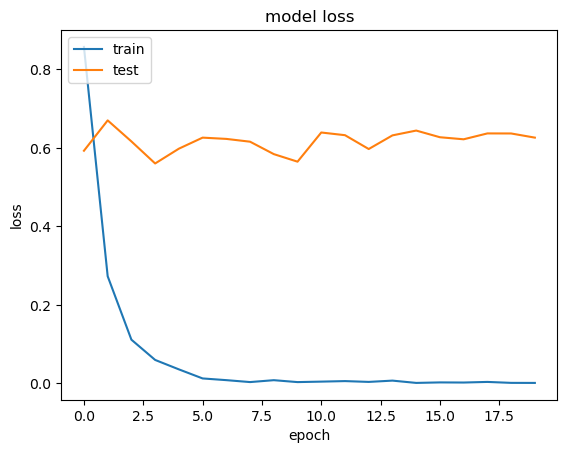

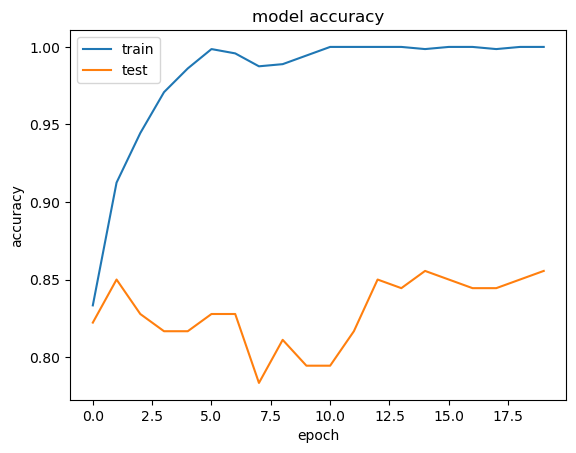

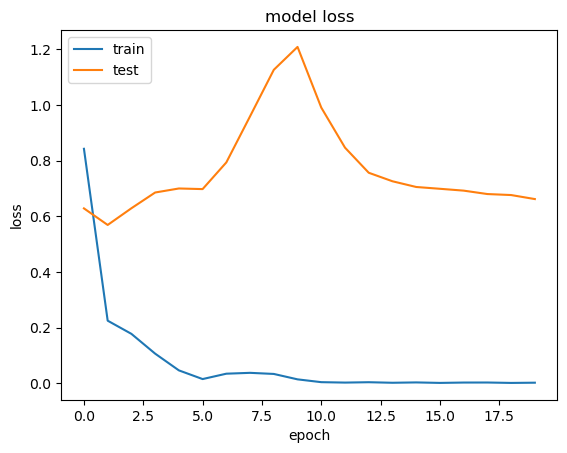

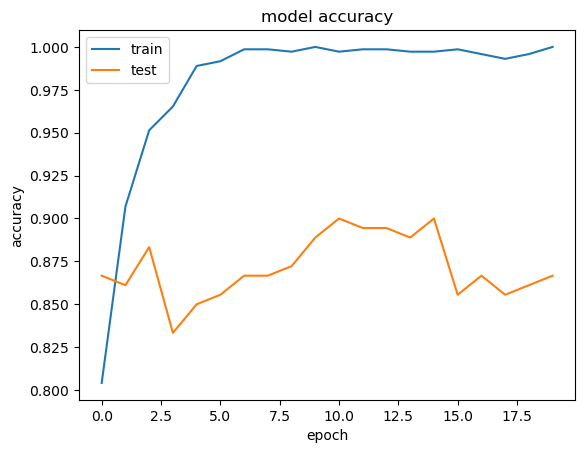

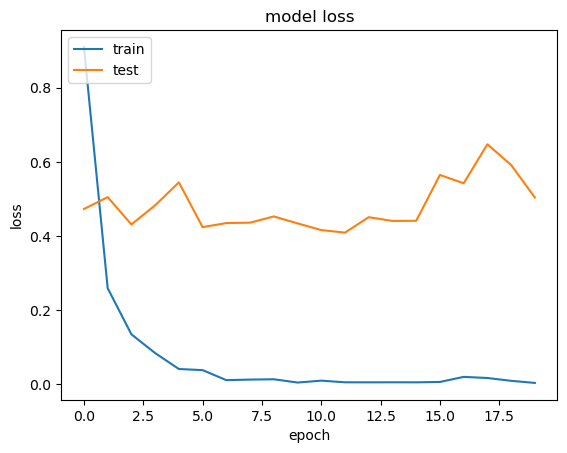

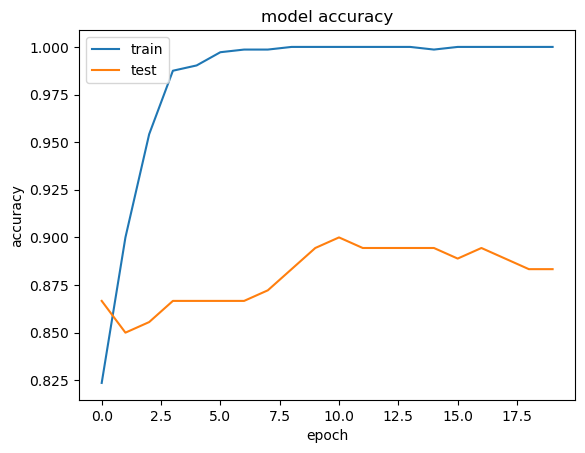

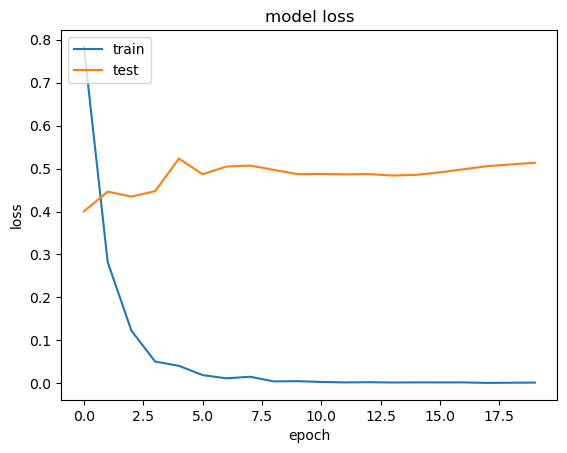

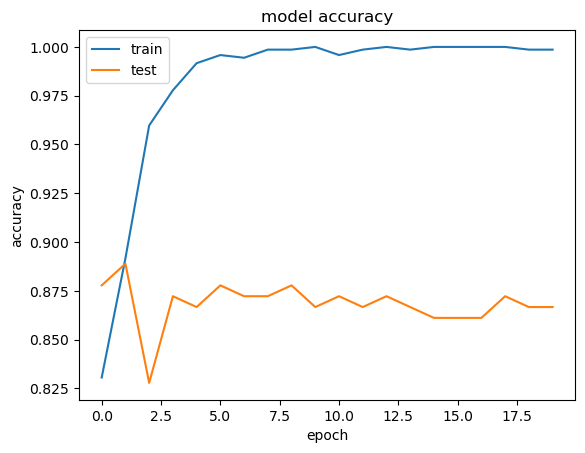

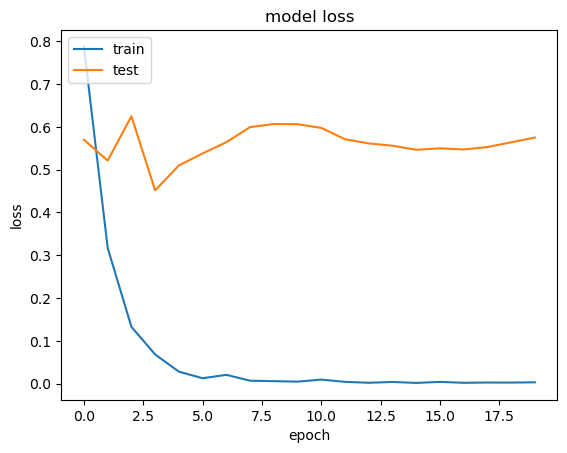

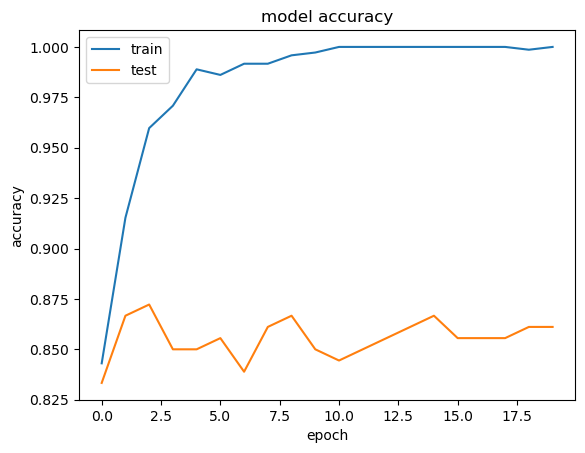

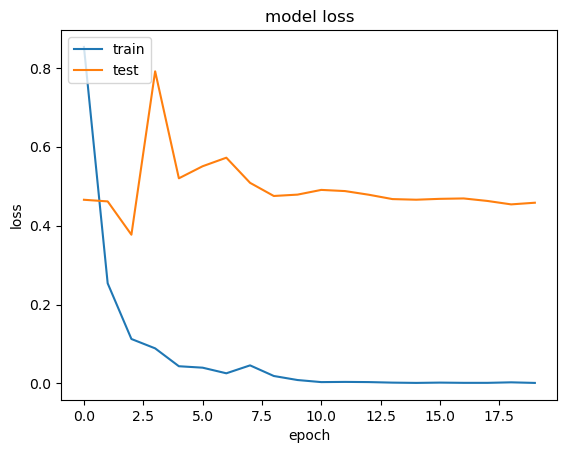

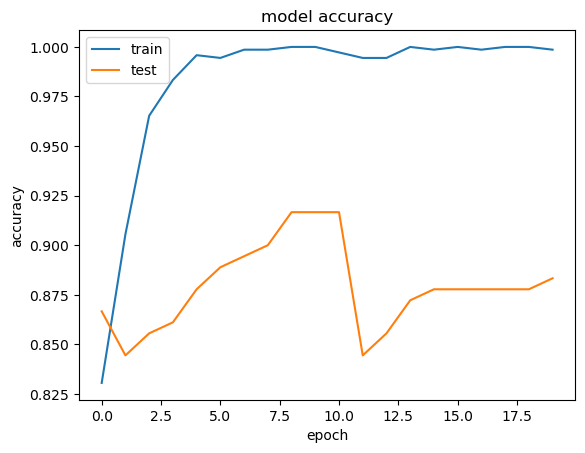

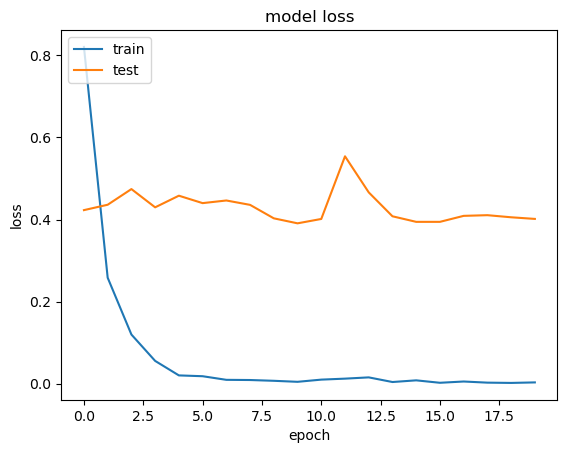

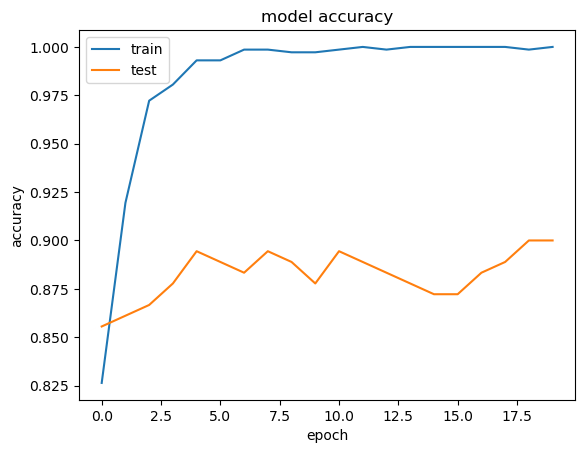

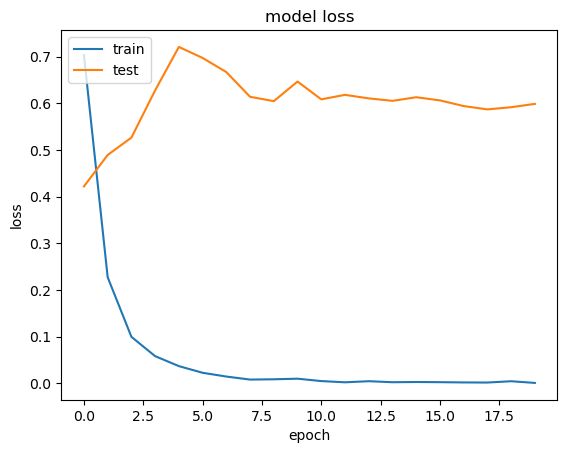

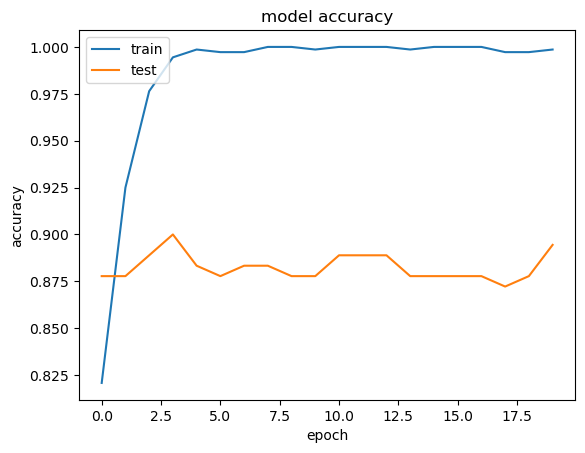

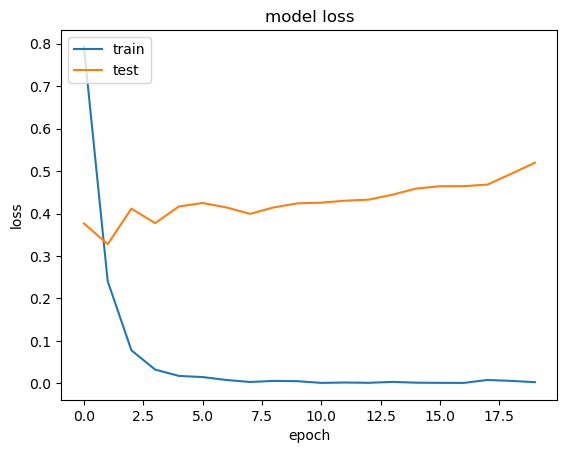

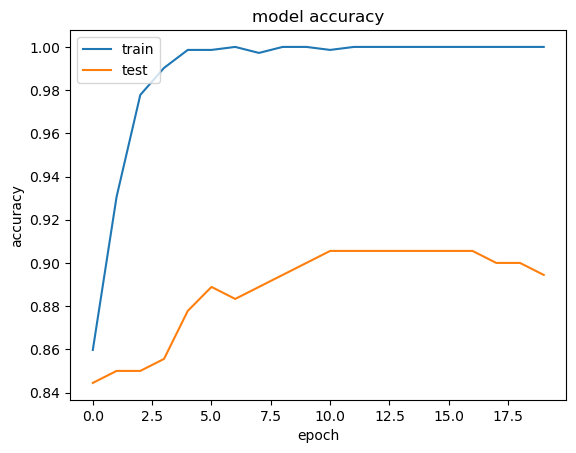

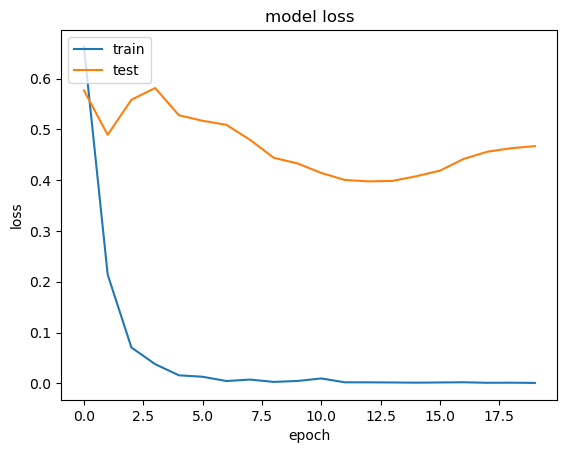

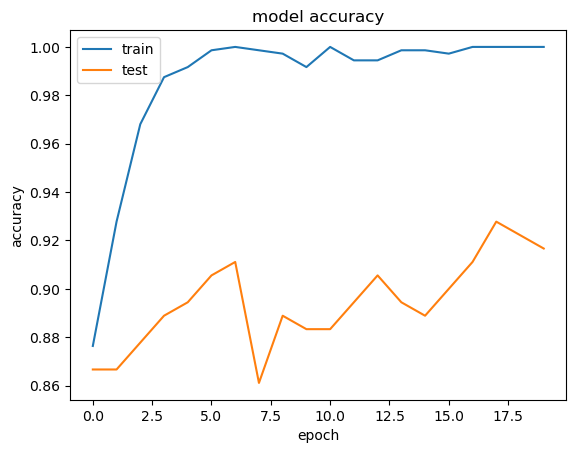

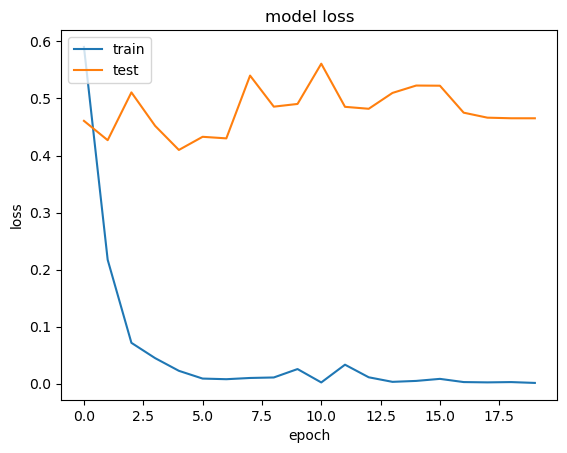

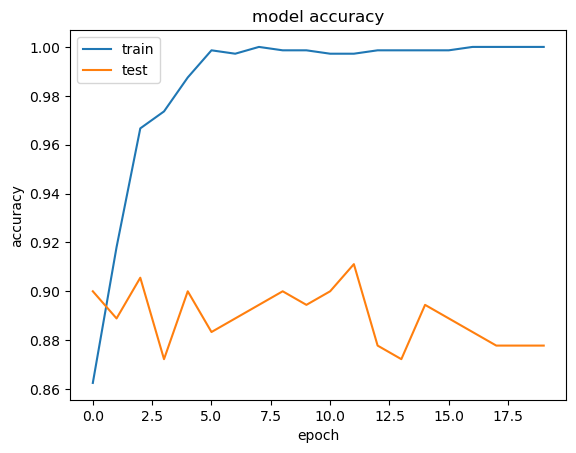

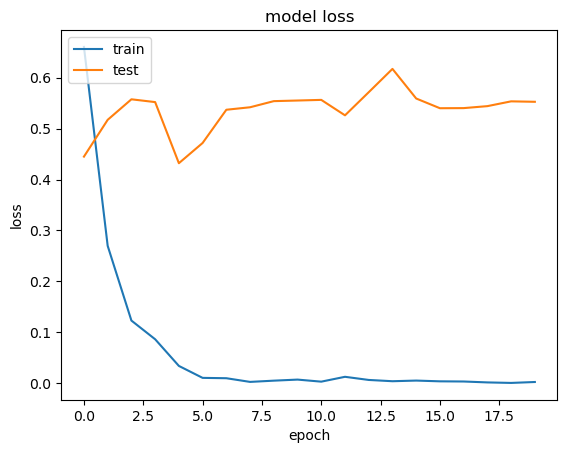

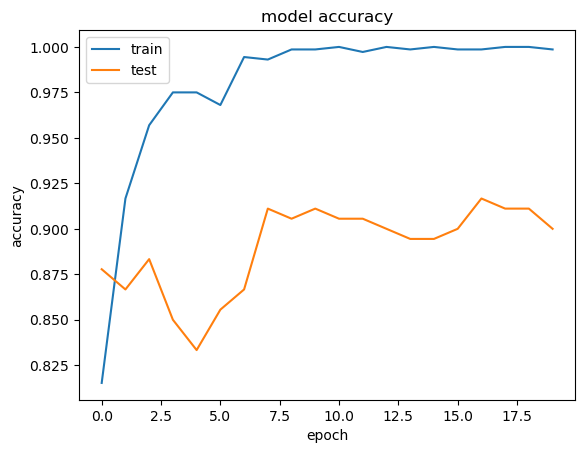

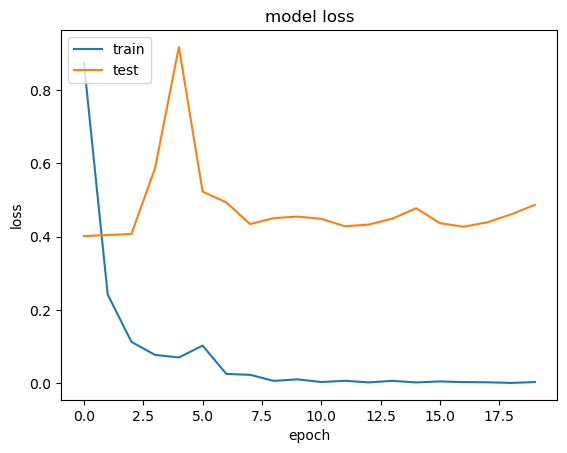

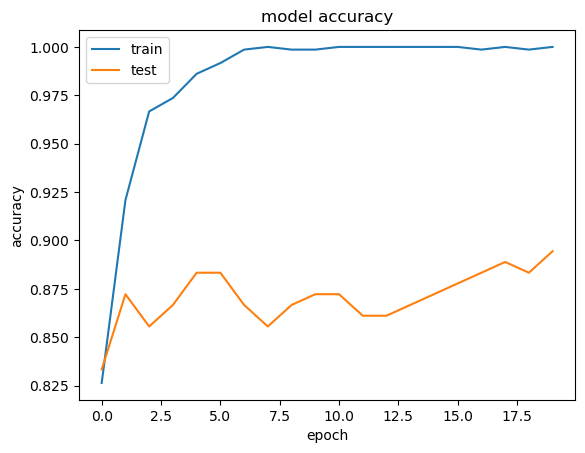

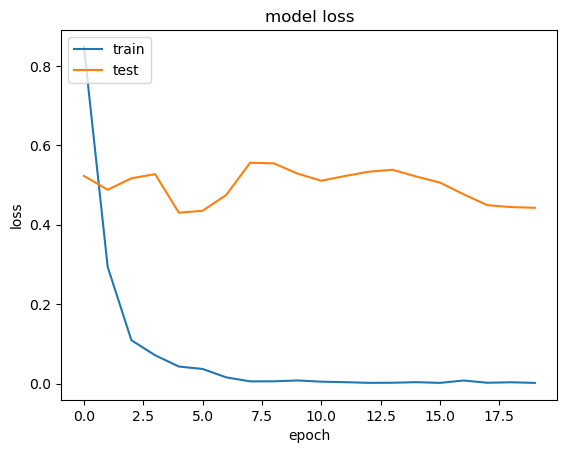

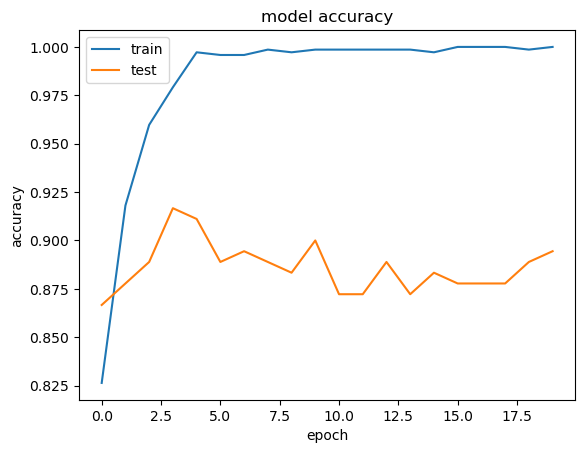

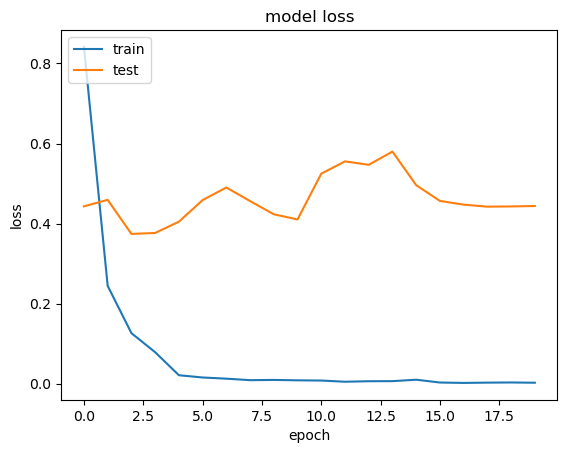

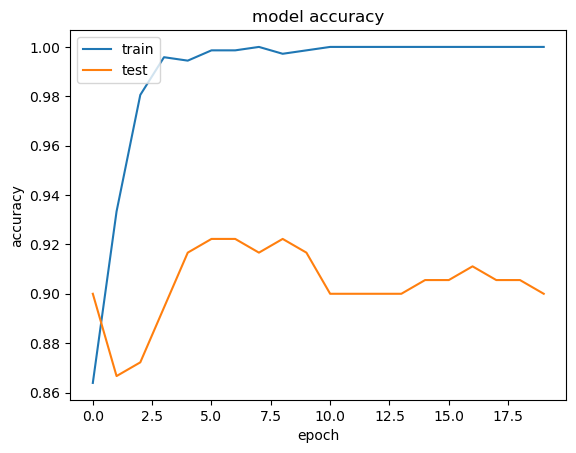

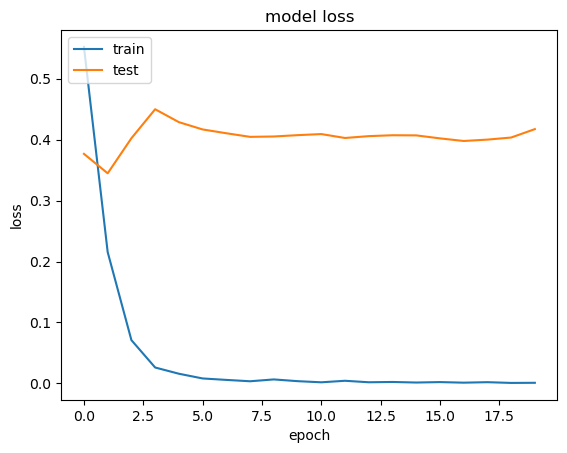

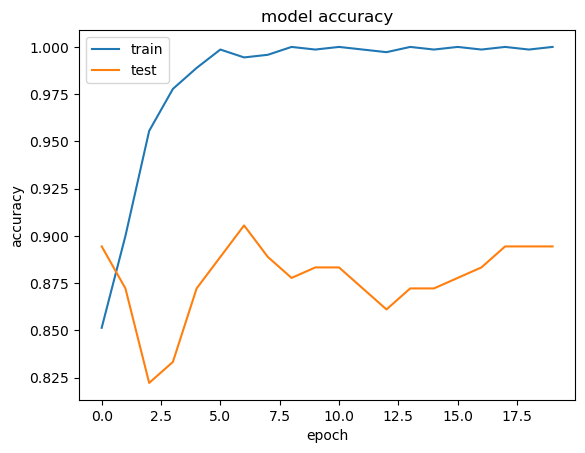

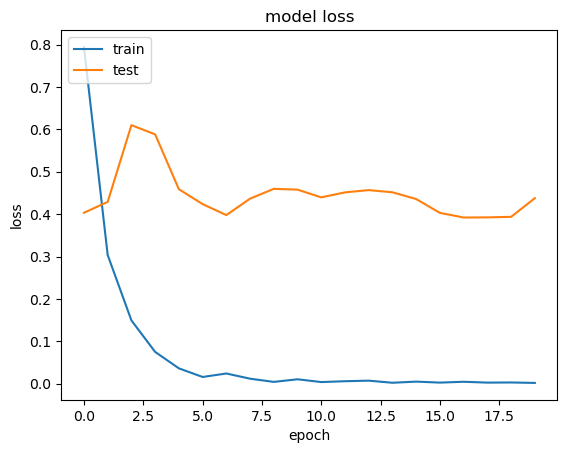

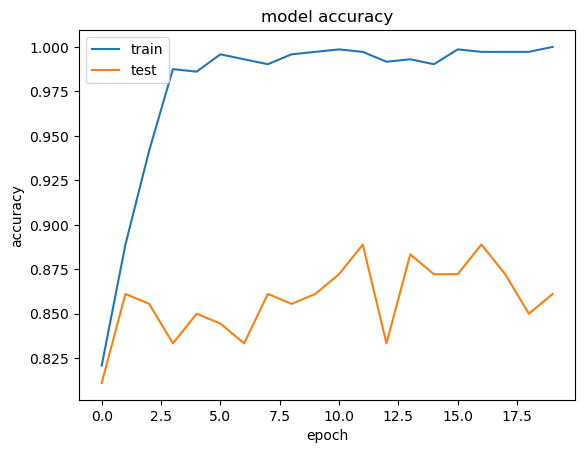

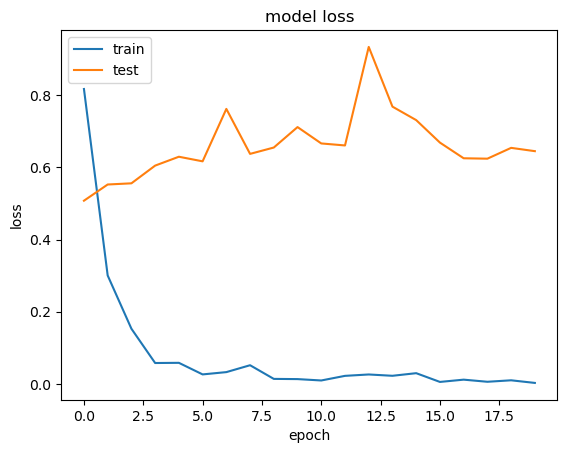

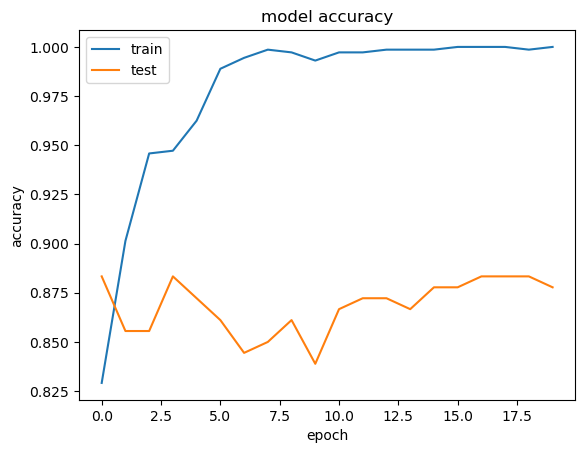

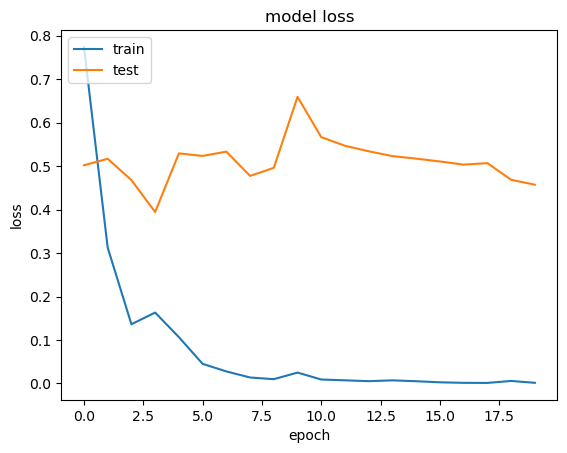

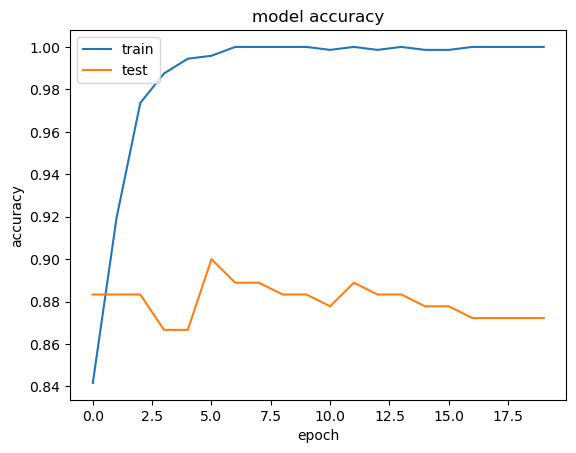

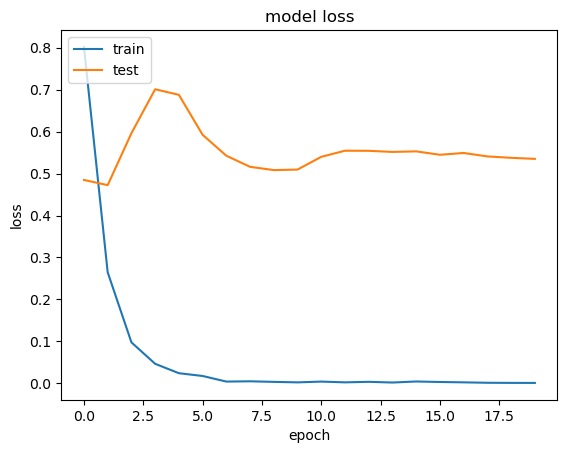

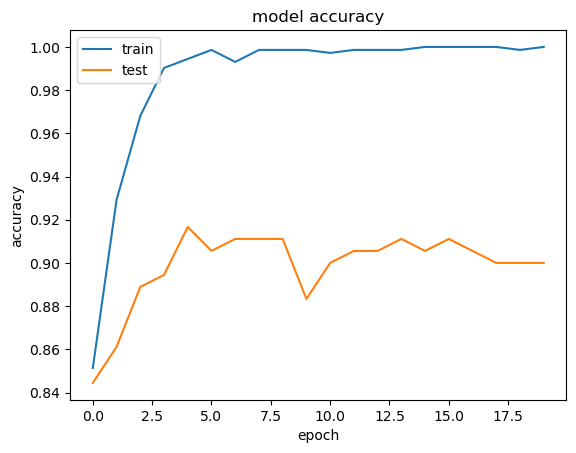

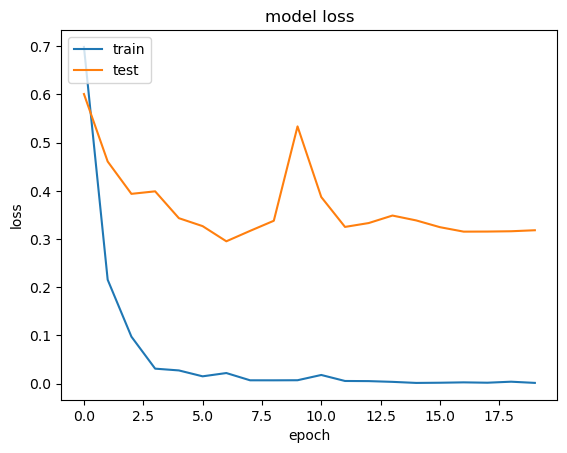

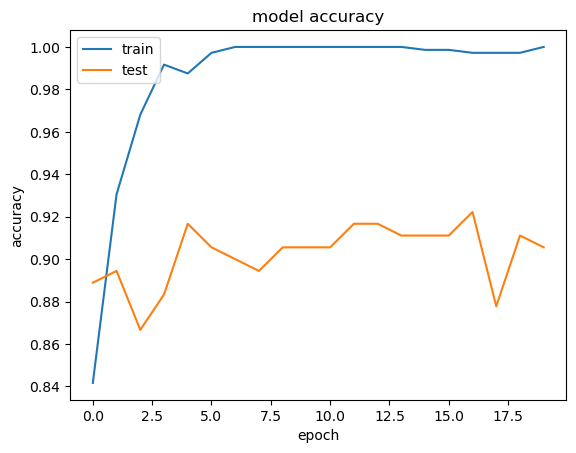

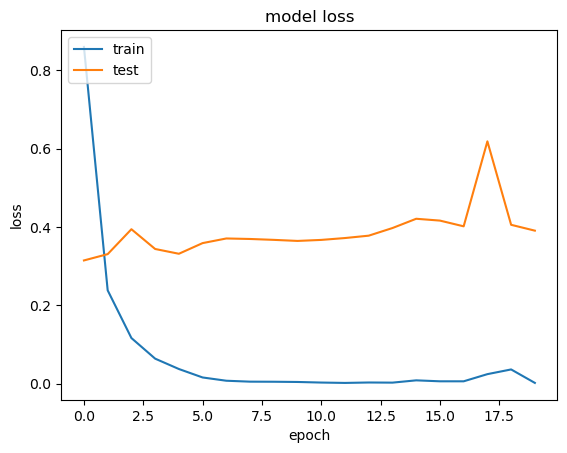

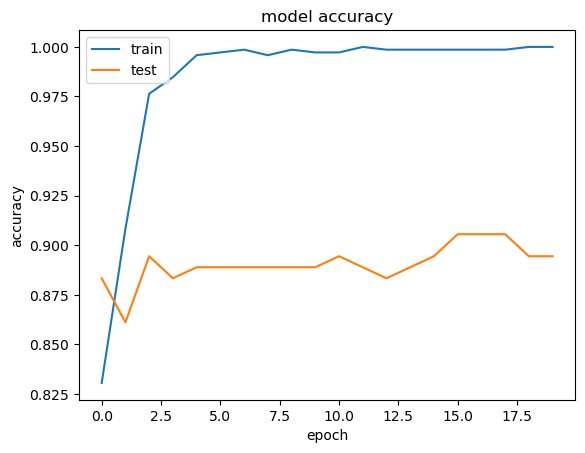

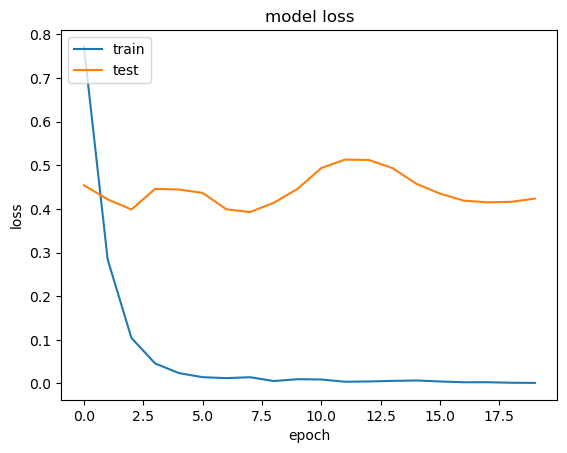

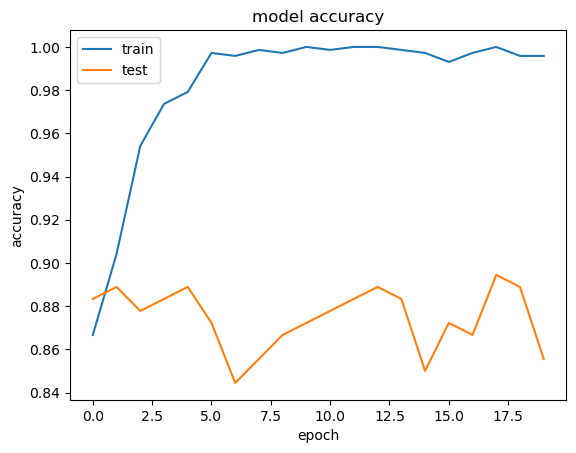

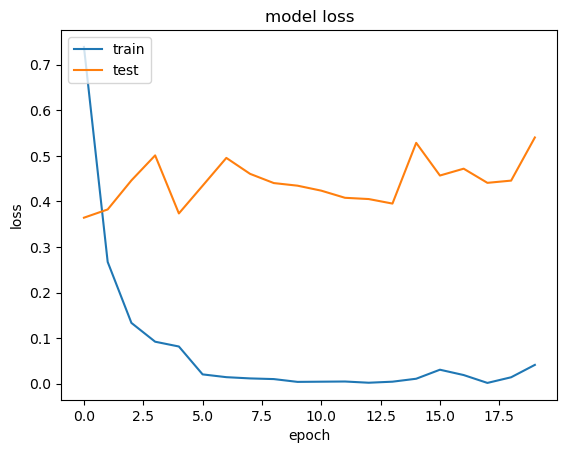

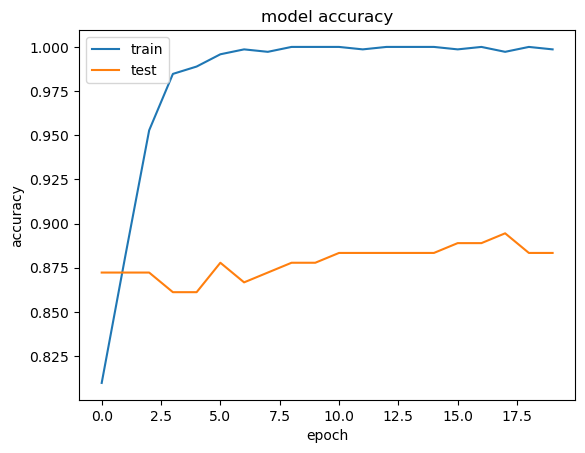

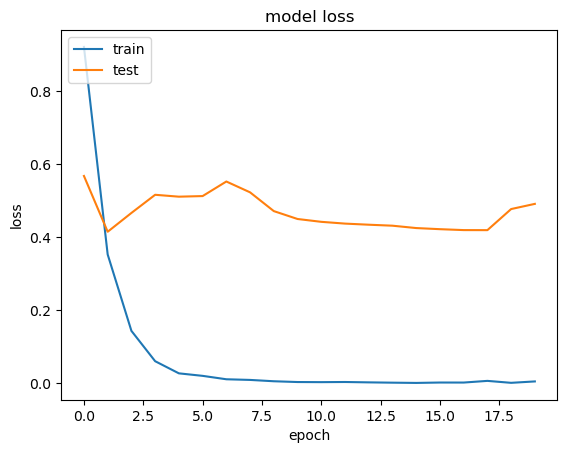

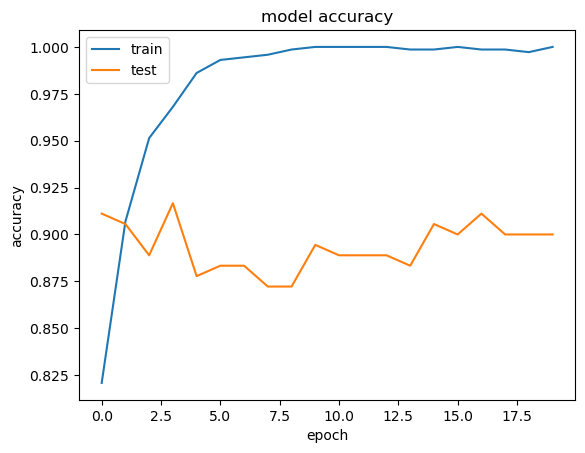

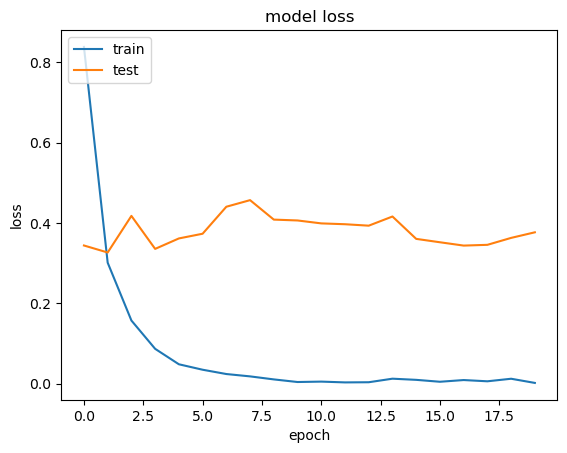

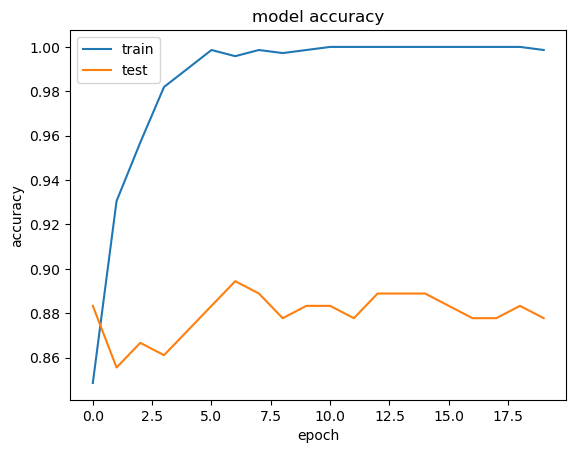

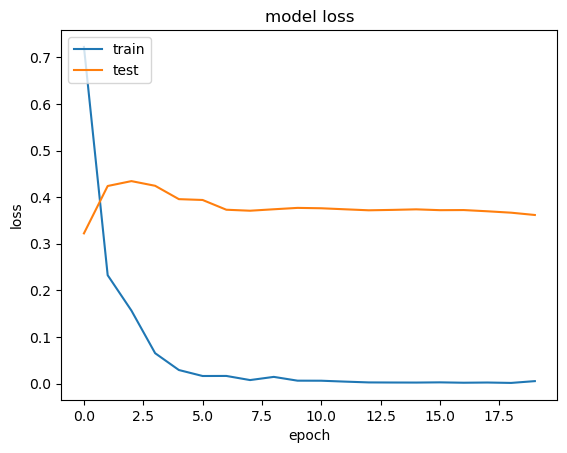

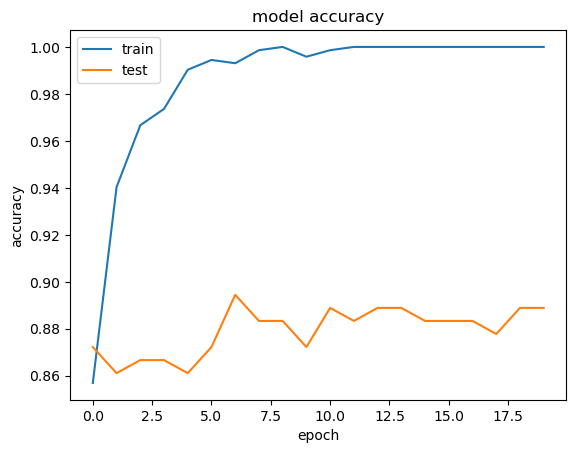

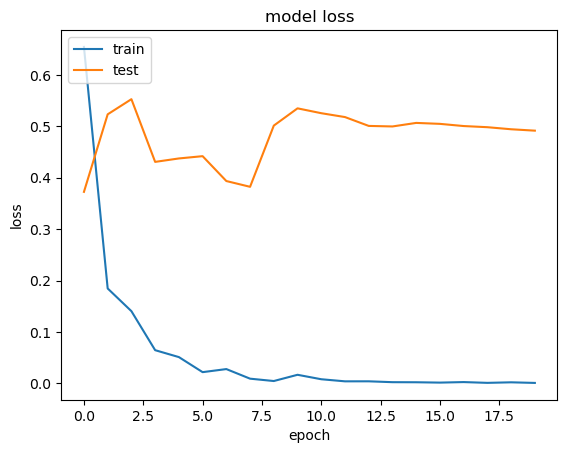

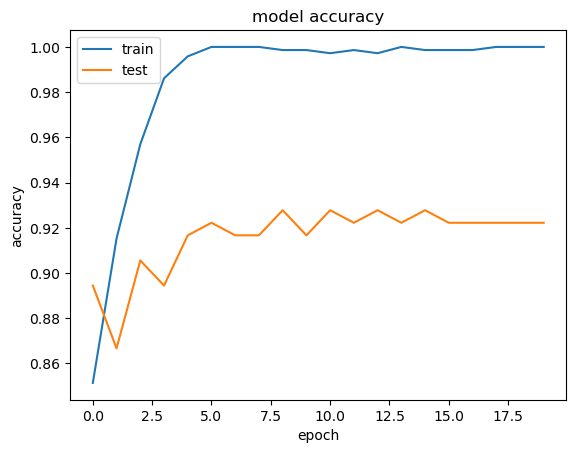

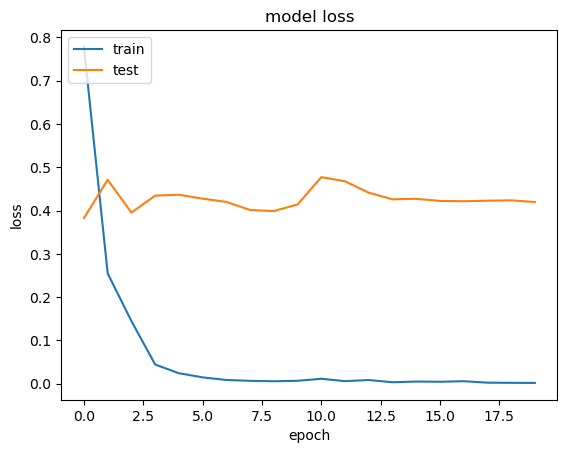

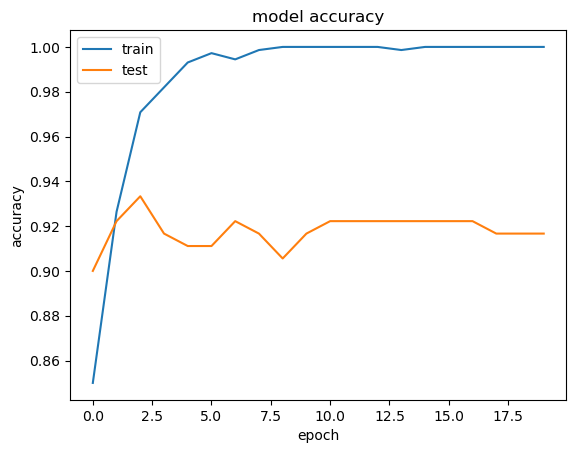

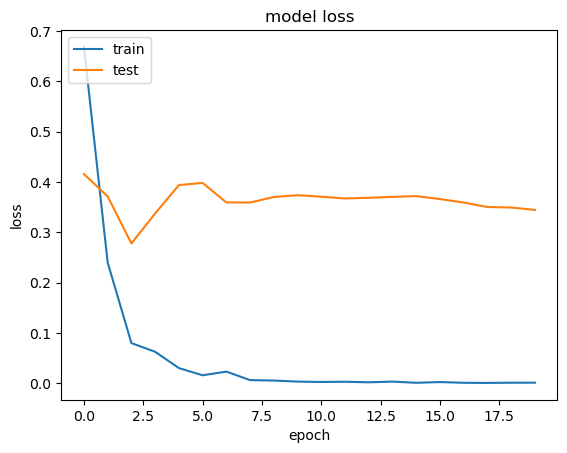

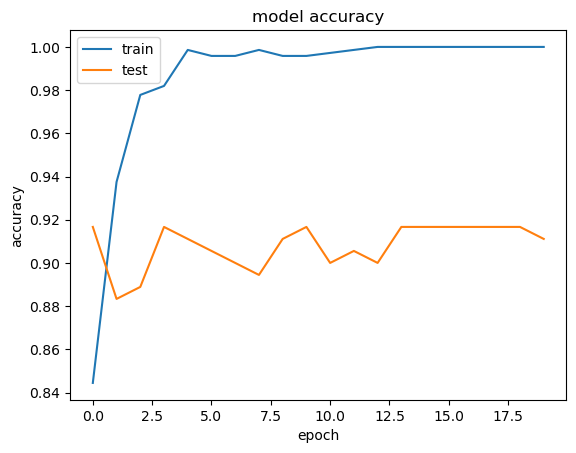

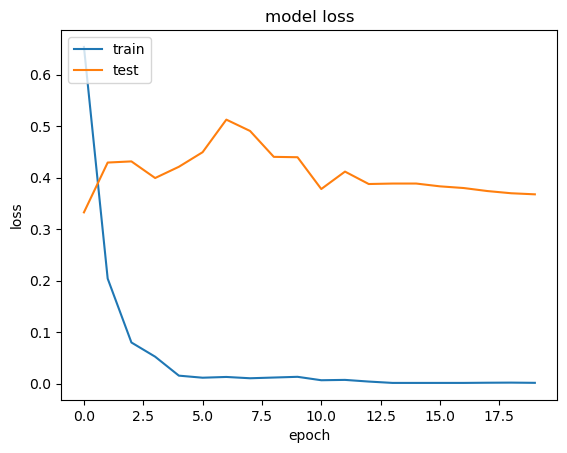

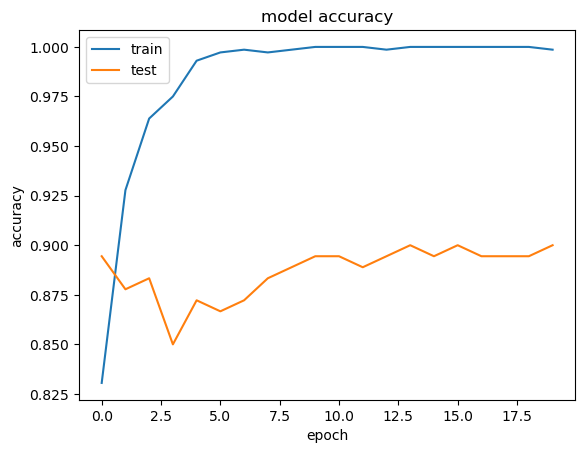

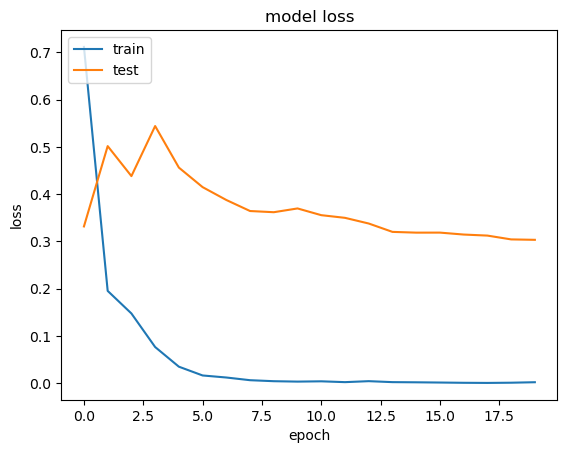

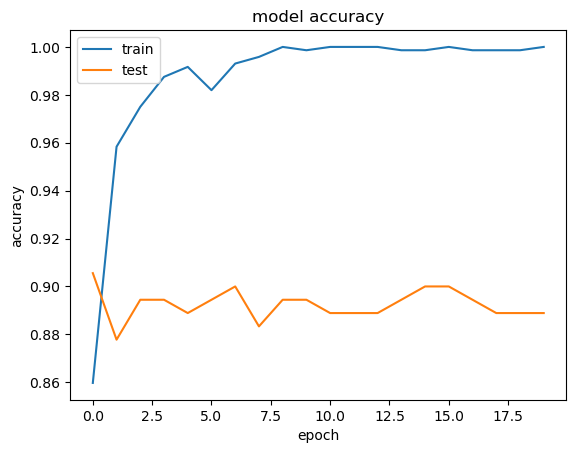

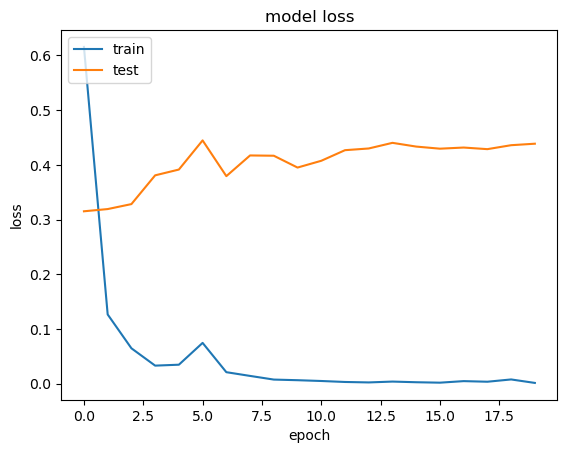

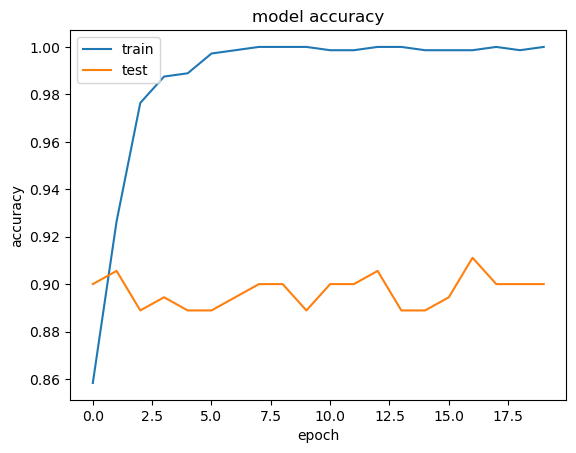

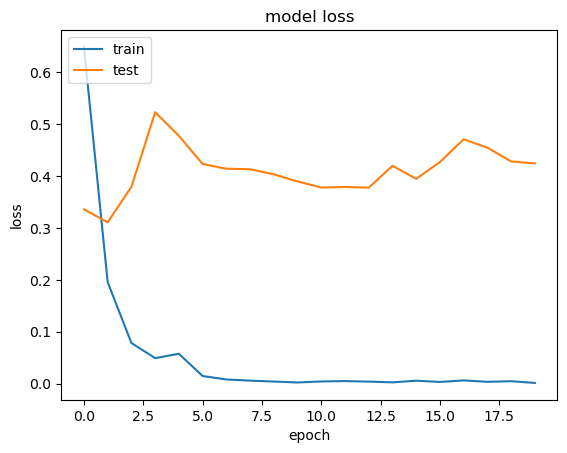

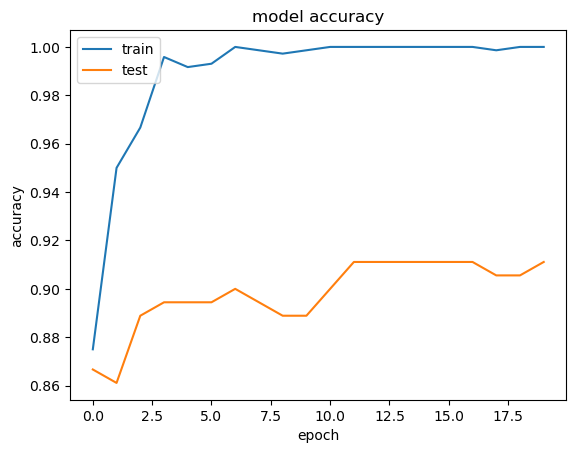

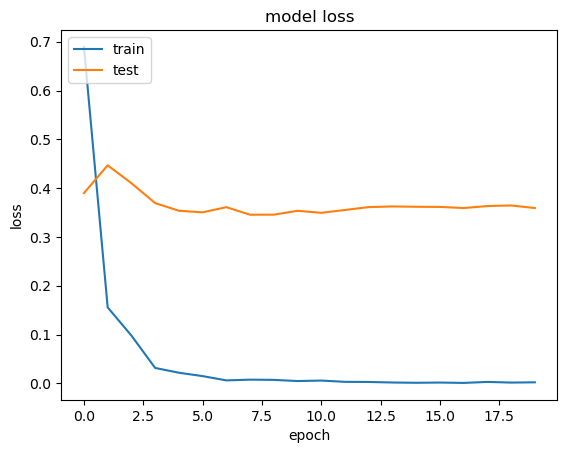

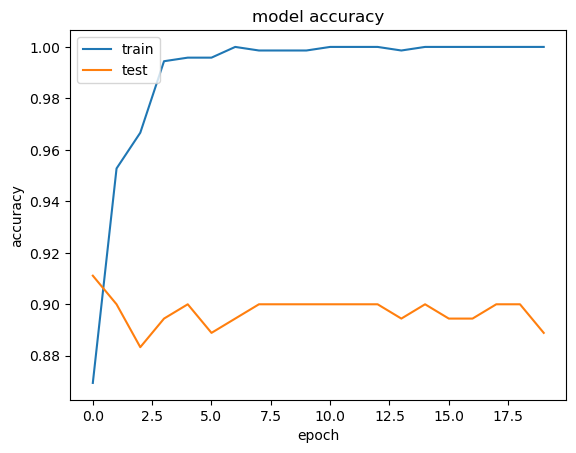

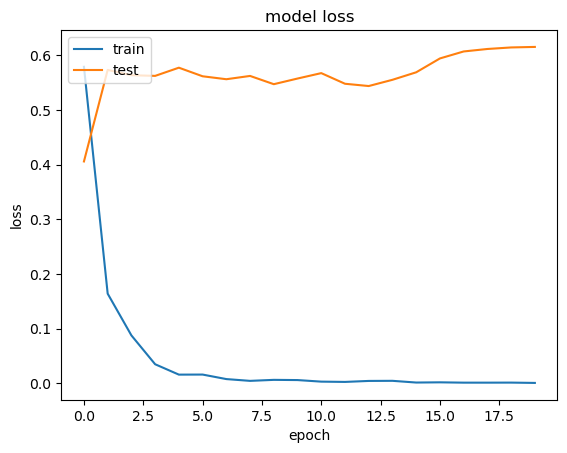

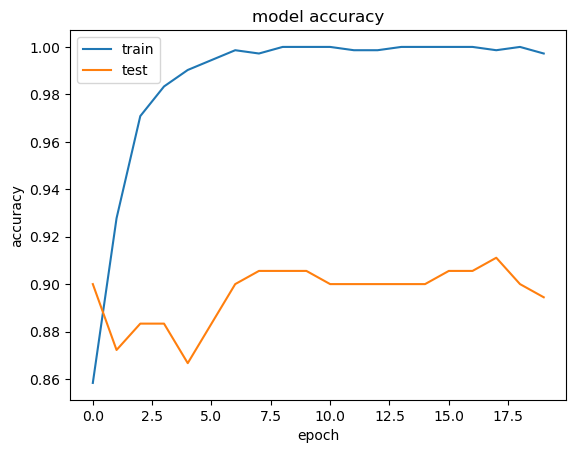

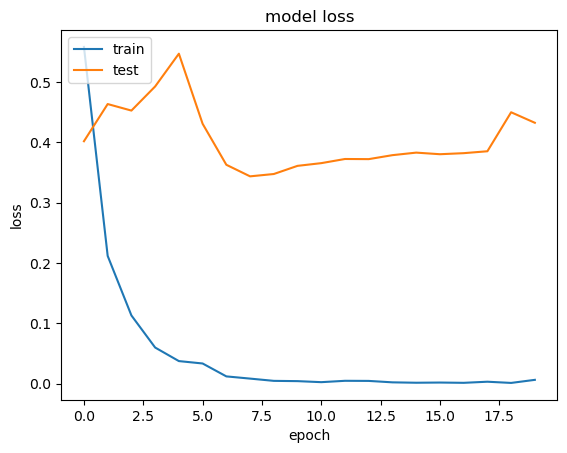

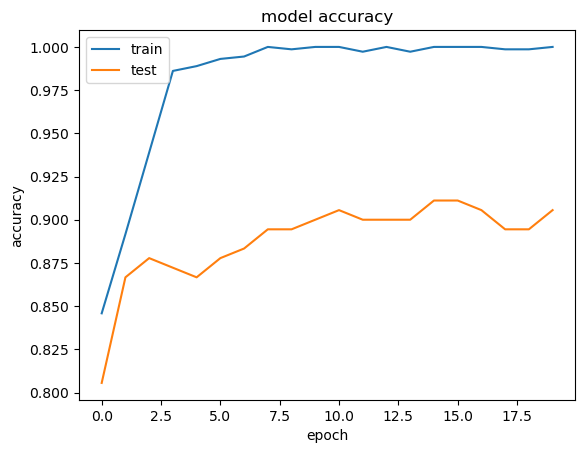

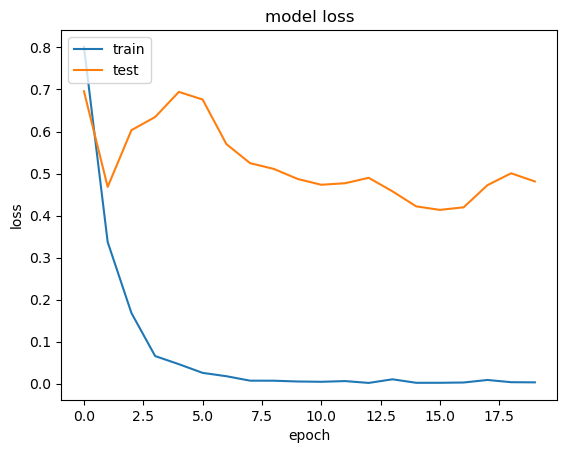

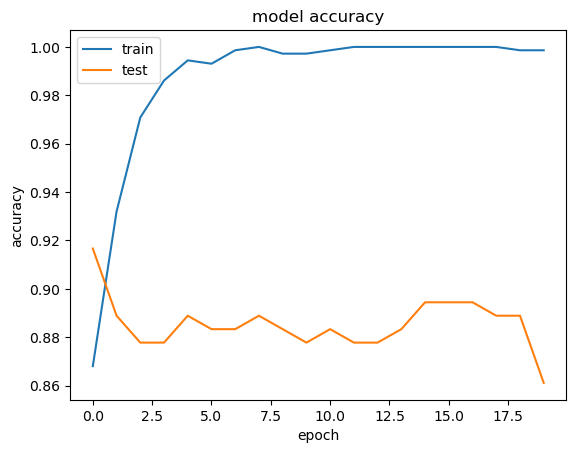

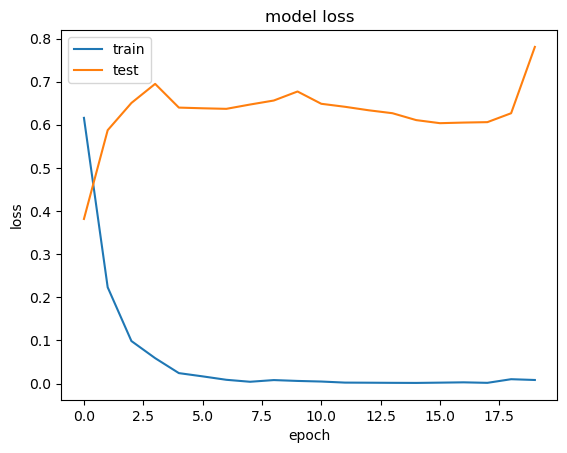

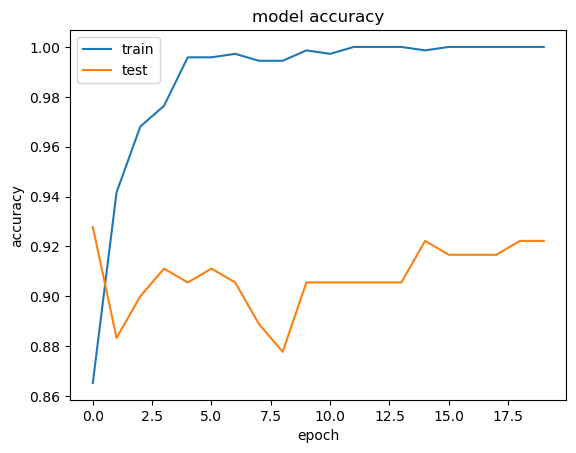

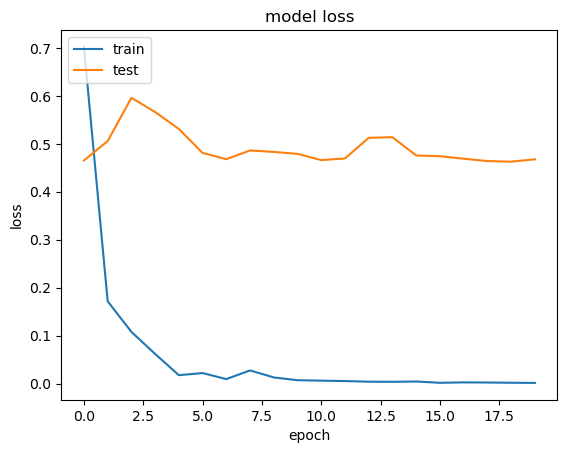

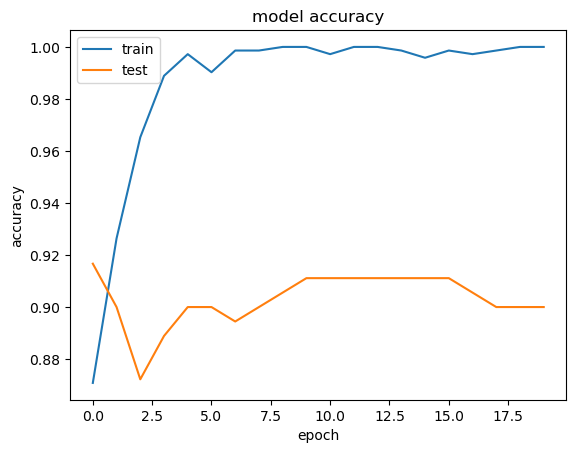

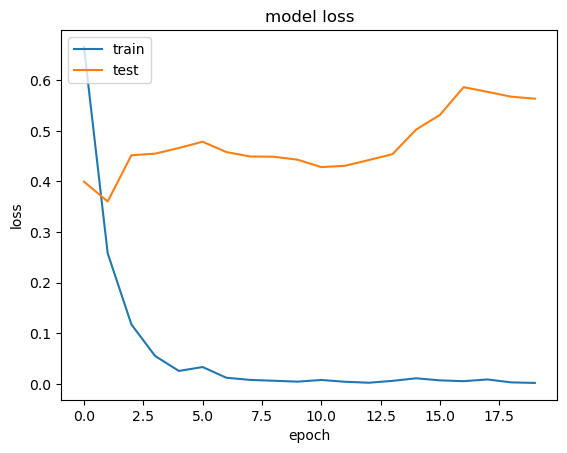

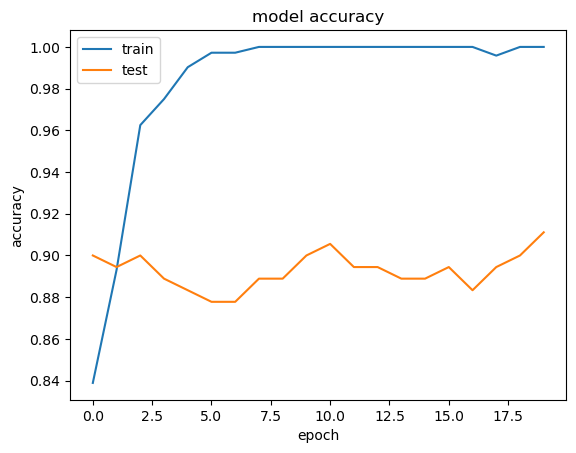

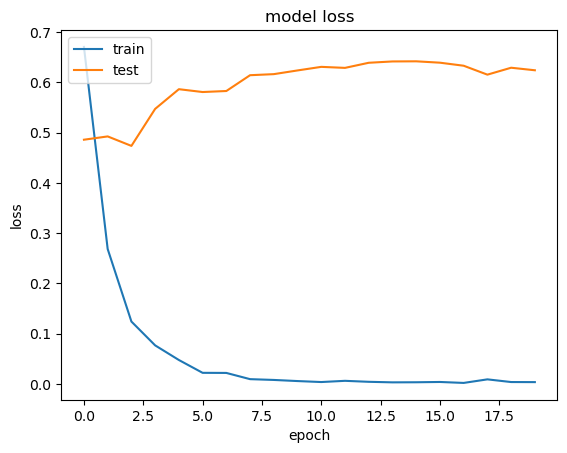

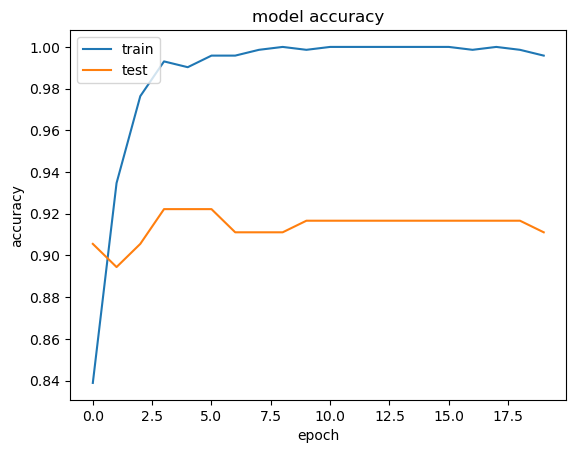

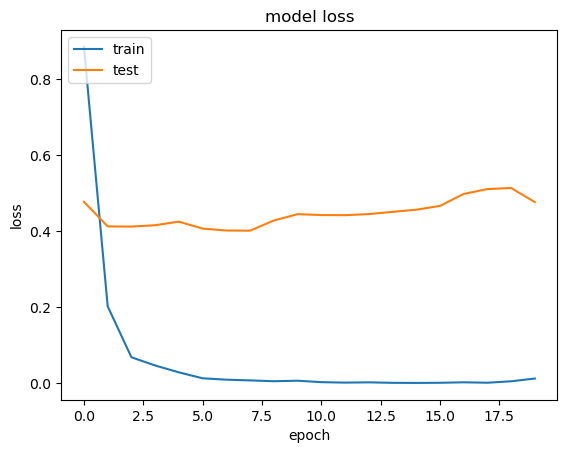

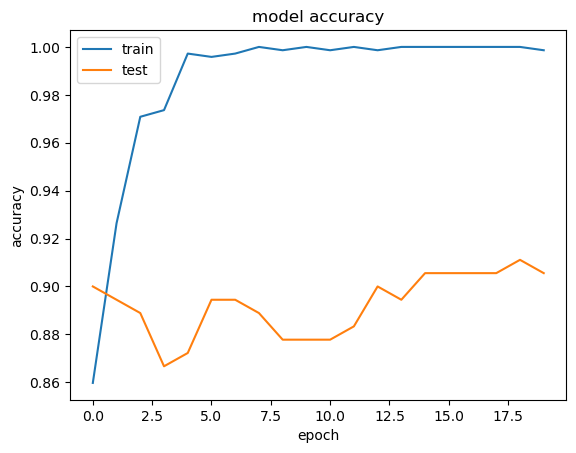

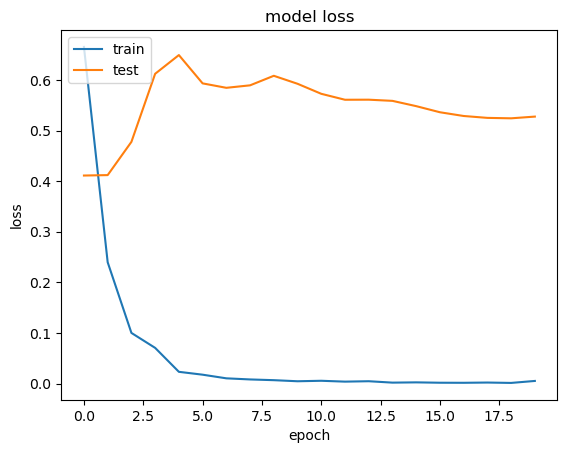

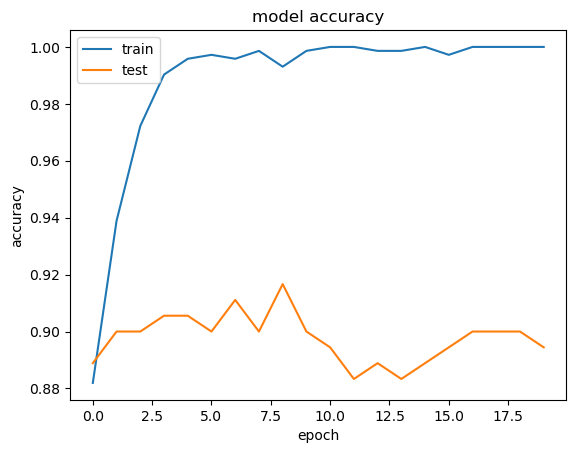

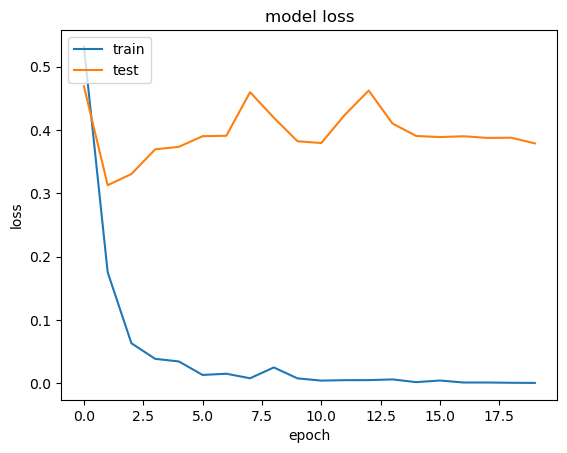

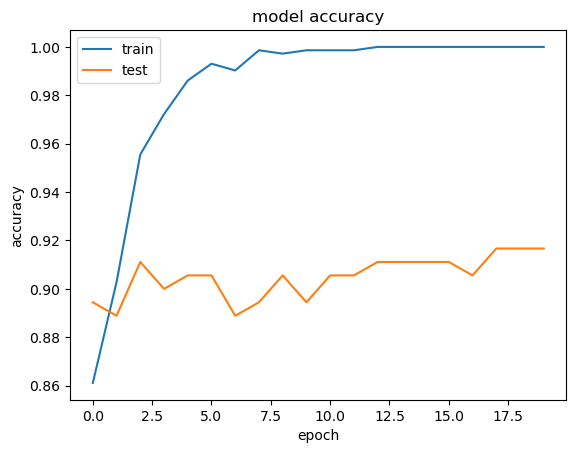

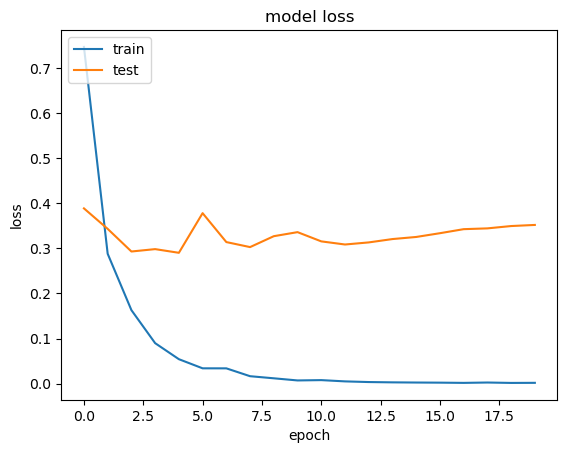

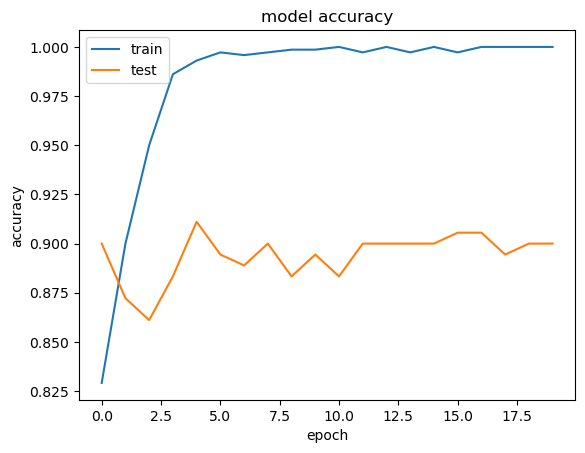

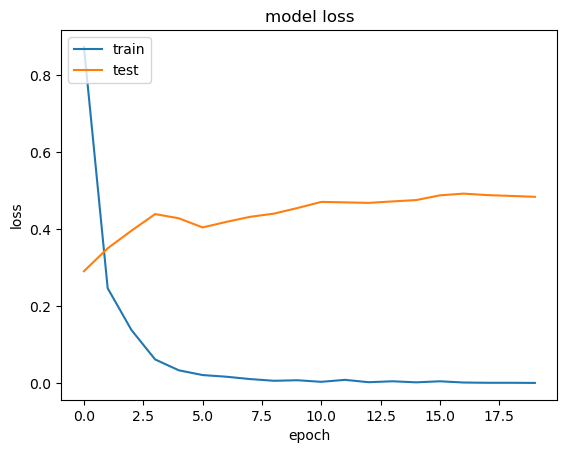

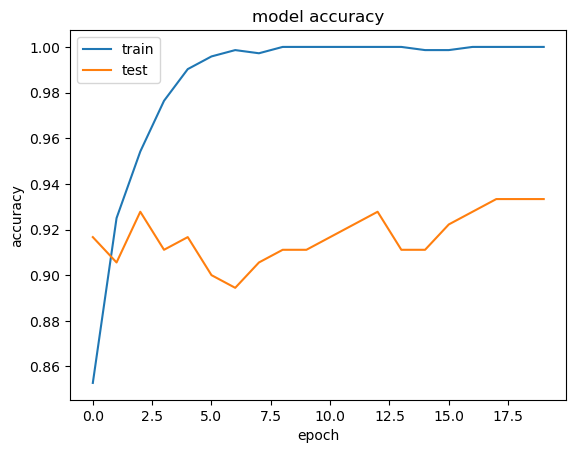

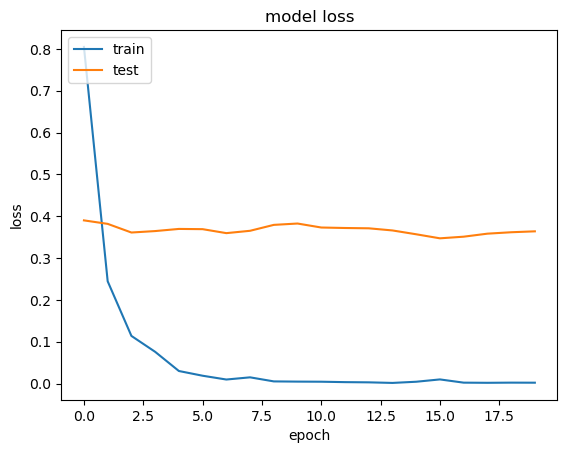

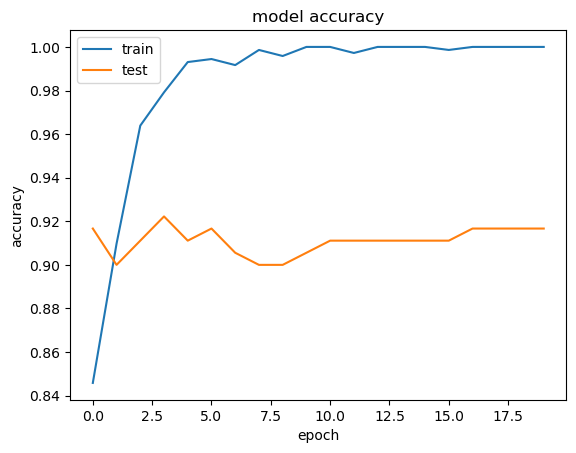

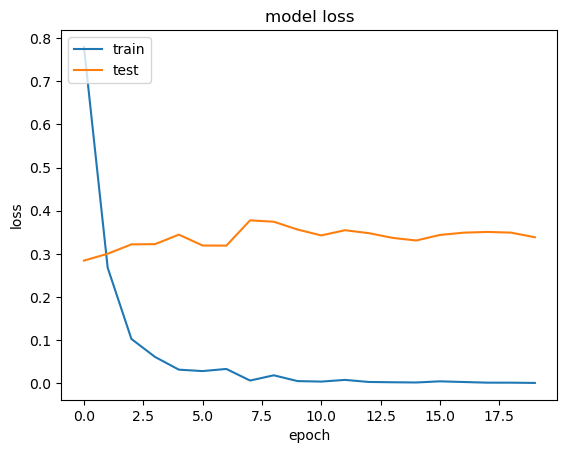

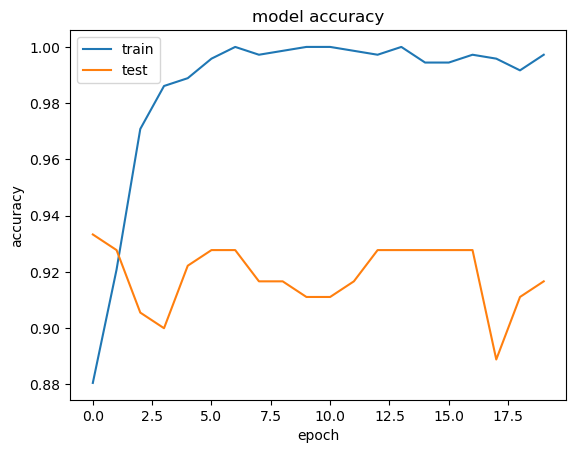

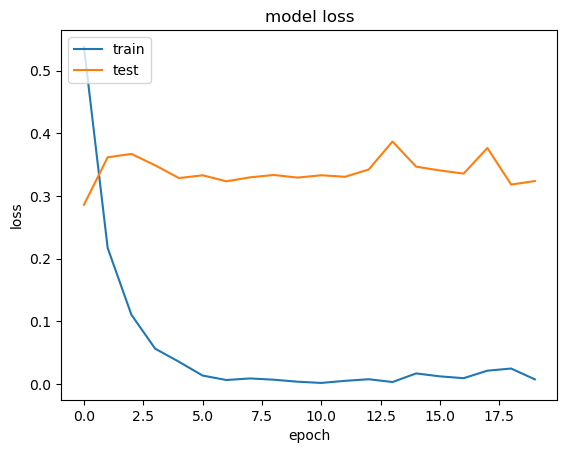

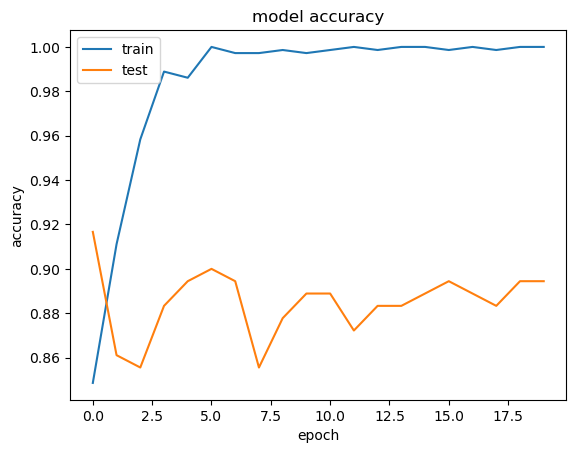

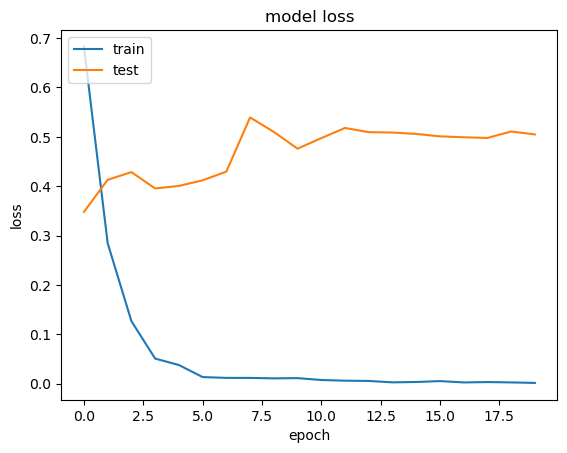

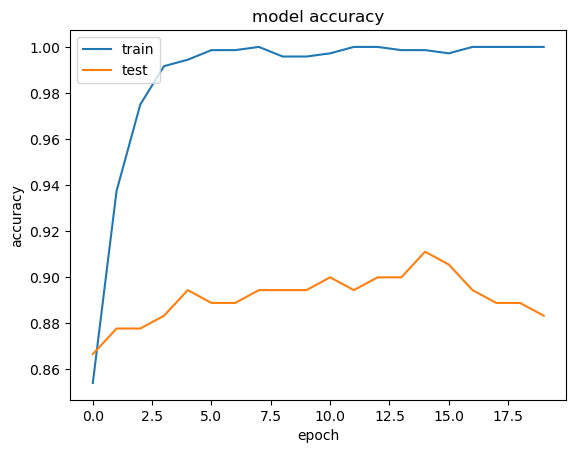

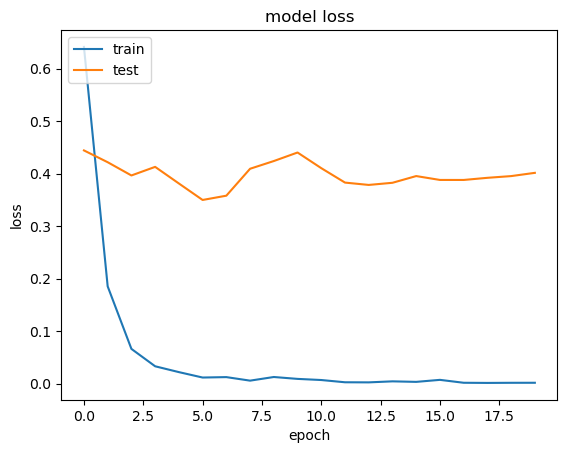

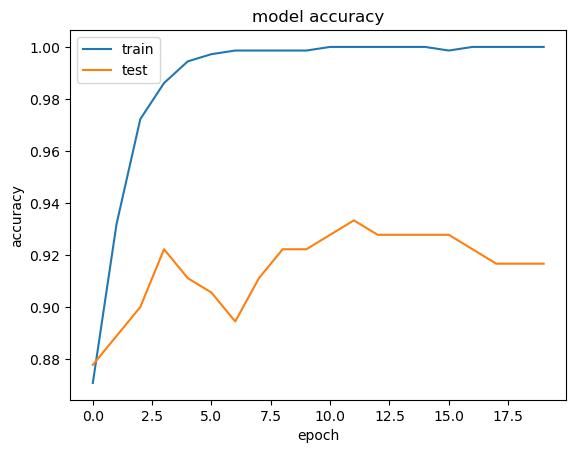

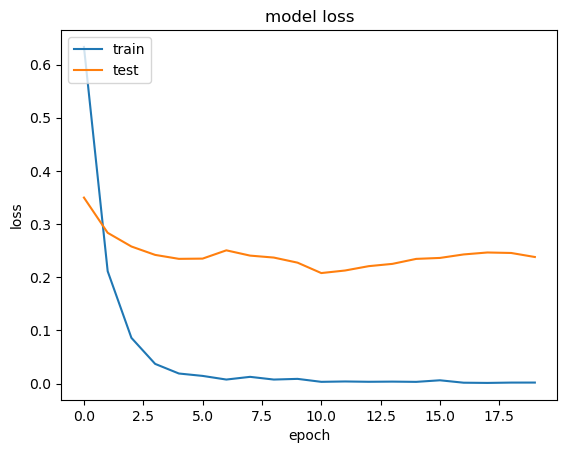

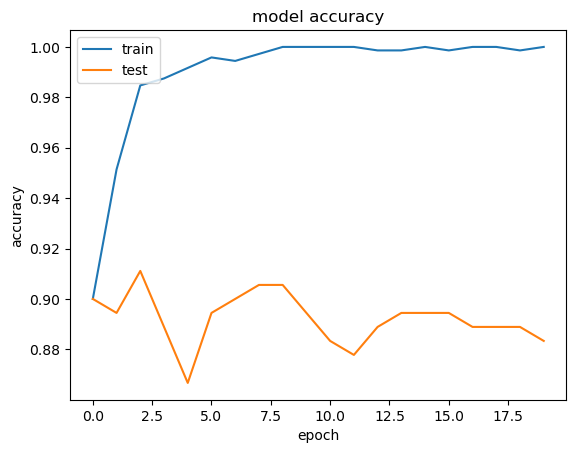

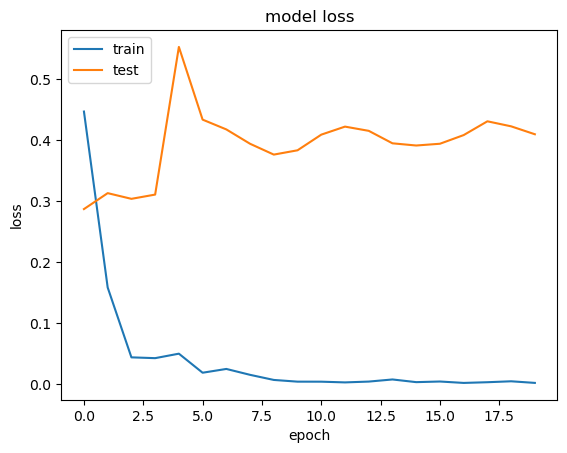

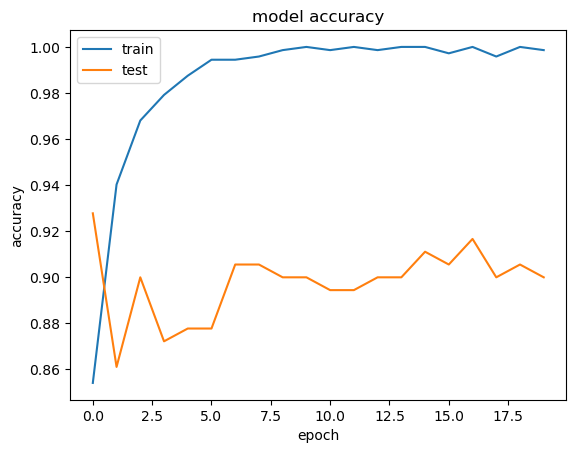

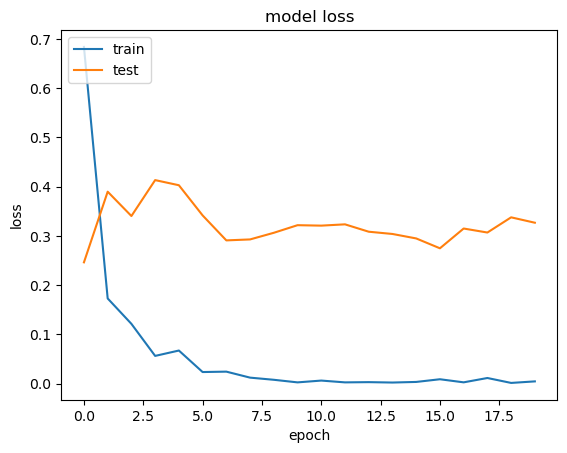

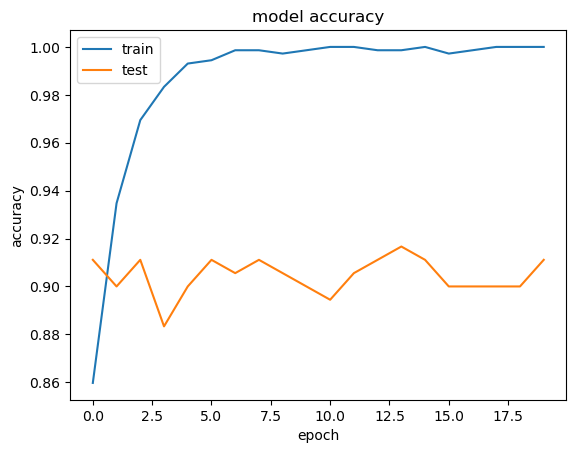

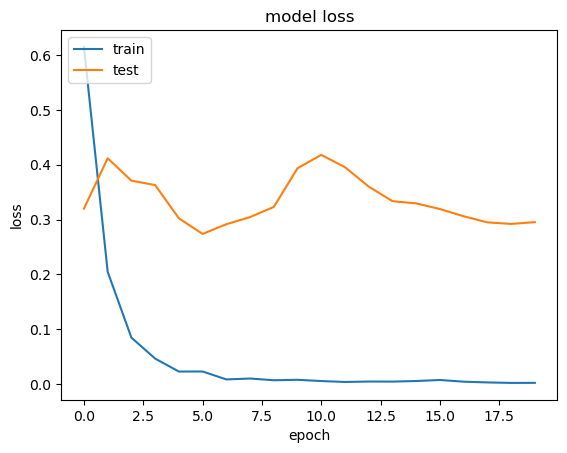

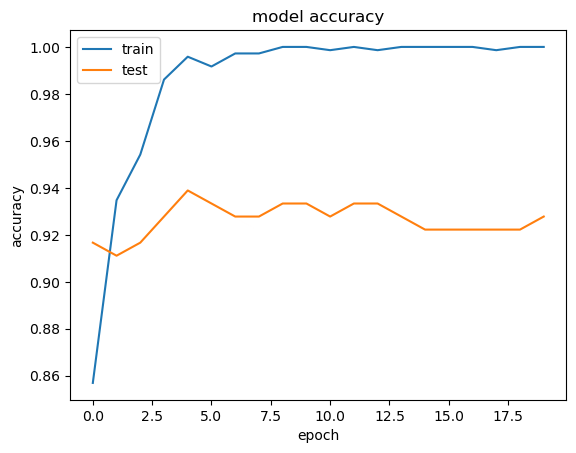

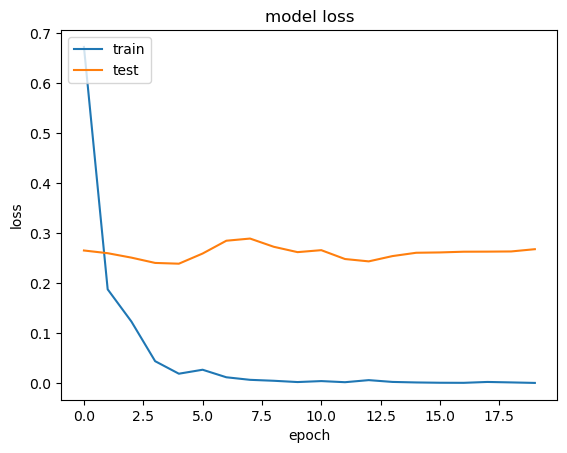

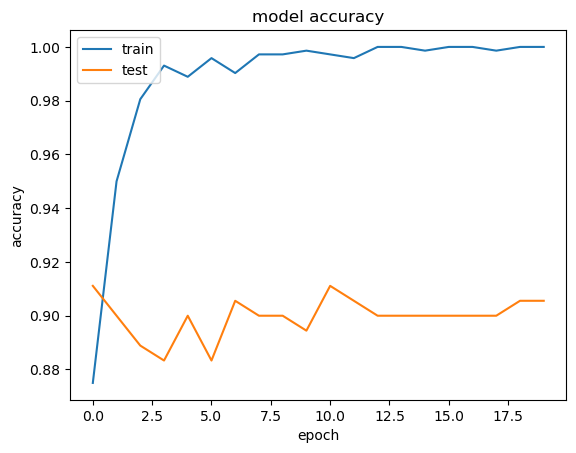

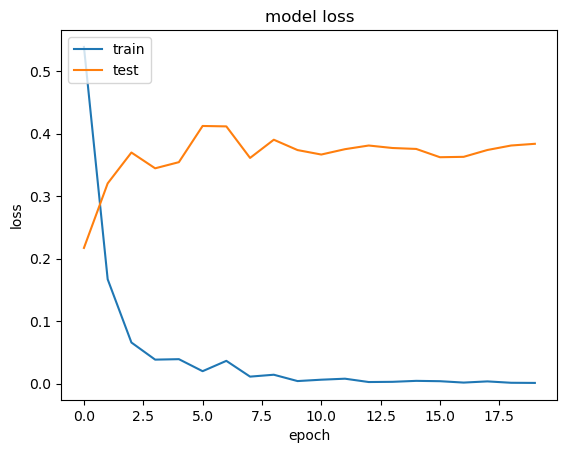

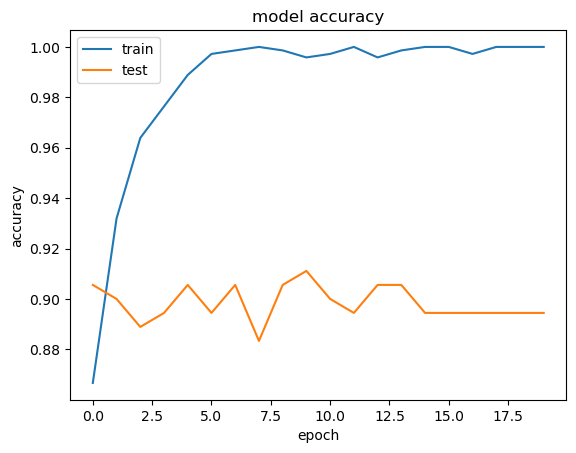

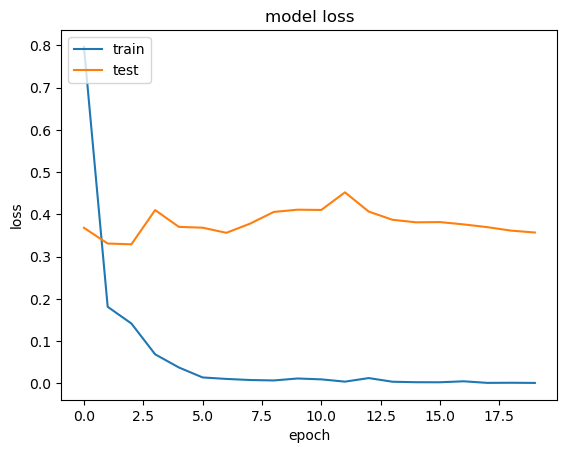

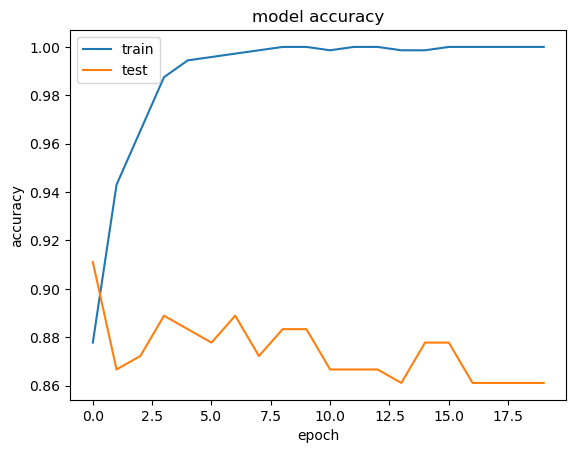

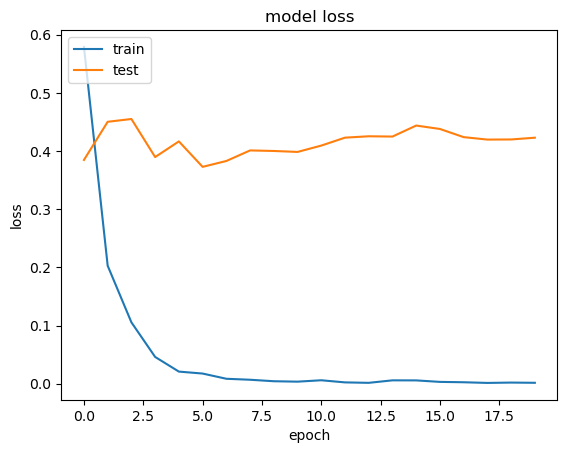

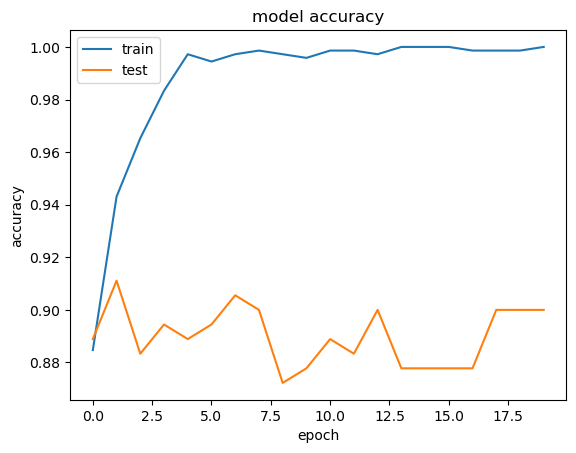

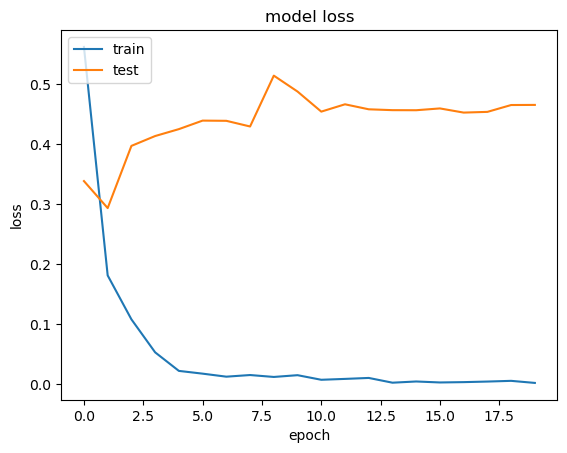

In [92]:
for history in histories:
    # accuracy plot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # loss plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [93]:
# Save the model
model.save('wafer_defect_classification_model.h5')